In [51]:
from tensorflow import keras
from tensorflow.keras import layers

n_steps, n_feats = X_train.shape[1], X_train.shape[2]

inputs = keras.Input(shape=(n_steps, n_feats))
x = layers.SpatialDropout1D(0.2)(inputs)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=7e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

ckpt_path = "/kaggle/working/gru_market_ema_best.keras"
cbs = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=512,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)
print("✅ Saved best to:", ckpt_path)


Epoch 1/50
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5200 - loss: 0.6907
Epoch 1: val_loss improved from inf to 0.69754, saving model to /kaggle/working/gru_market_ema_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5206 - loss: 0.6906 - val_accuracy: 0.5206 - val_loss: 0.6975 - learning_rate: 7.0000e-04
Epoch 2/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5386 - loss: 0.6888
Epoch 2: val_loss improved from 0.69754 to 0.69447, saving model to /kaggle/working/gru_market_ema_best.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5389 - loss: 0.6887 - val_accuracy: 0.5392 - val_loss: 0.6945 - learning_rate: 7.0000e-04
Epoch 3/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5387 - loss: 0.6864
Epoch 3: val_loss did not improve from 0.69447
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5388 - loss: 0.6864 - val_accuracy: 0.5496 - val_loss: 0.6970 - learning_rate: 7.0000e-04
Epoch 4/50
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

In [52]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, brier_score_loss

def eval_with_best_threshold(Xv, yv):
    p = model.predict(Xv, verbose=0).ravel()
    roc = roc_auc_score(yv, p)
    pr  = average_precision_score(yv, p)

    prec, rec, thr = precision_recall_curve(yv, p)
    f1s = 2*prec*rec/(prec+rec+1e-9)
    i = np.nanargmax(f1s)
    best_thr = thr[max(i-1, 0)] if len(thr) > 0 else 0.5

    yhat = (p >= best_thr).astype(int)
    f1 = f1_score(yv, yhat)
    brier = brier_score_loss(yv, p)
    return {"roc":roc, "pr":pr, "f1":f1, "thr":best_thr, "brier":brier}

val_metrics = eval_with_best_threshold(X_val, y_val)
test_p = model.predict(X_test, verbose=0).ravel()
from sklearn.metrics import f1_score
yhat_test = (test_p >= val_metrics["thr"]).astype(int)
test_metrics = {
    "roc": roc_auc_score(y_test, test_p),
    "pr": average_precision_score(y_test, test_p),
    "f1": f1_score(y_test, yhat_test),
    "brier": brier_score_loss(y_test, test_p),
    "thr": val_metrics["thr"]
}

print("VAL  => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr: %.4f" %
      (val_metrics["roc"], val_metrics["pr"], val_metrics["f1"], val_metrics["brier"], val_metrics["thr"]))
print("TEST => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr(V): %.4f" %
      (test_metrics["roc"], test_metrics["pr"], test_metrics["f1"], test_metrics["brier"], test_metrics["thr"]))


VAL  => ROC-AUC: 0.6448 | PR-AUC: 0.5240 | F1: 0.5857 | Brier: 0.2457 | Thr: 0.4638
TEST => ROC-AUC: 0.4976 | PR-AUC: 0.5630 | F1: 0.5760 | Brier: 0.2555 | Thr(V): 0.4638


In [54]:
# === Transformer baseline (technical + regime) ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

n_steps, n_feats = X_train.shape[1], X_train.shape[2]

# Positional encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        pos_enc = self.pos_encoding[:, :seq_len, :]
        return x + pos_enc

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Build model
inputs = keras.Input(shape=(n_steps, n_feats))
x = PositionalEncoding(n_feats)(inputs)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

ckpt_path = "/kaggle/working/transformer_tech_regime_best.keras"
cbs = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1
)

print("✅ Transformer model saved to:", ckpt_path)


Epoch 1/50


I0000 00:00:1761454491.743259     143 service.cc:148] XLA service 0x7dc10002eb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761454491.745926     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761454491.745948     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/128 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4559 - loss: 0.9147 

I0000 00:00:1761454499.729481     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5055 - loss: 0.8009
Epoch 1: val_loss improved from inf to 0.68895, saving model to /kaggle/working/transformer_tech_regime_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - accuracy: 0.5055 - loss: 0.8006 - val_accuracy: 0.5486 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5139 - loss: 0.7140
Epoch 2: val_loss improved from 0.68895 to 0.68236, saving model to /kaggle/working/transformer_tech_regime_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5140 - loss: 0.7139 - val_accuracy: 0.6299 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 3/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5229 - loss: 0.7003
Epoch 3: val_loss improved from 0.68236 to 0.66874, saving model to /kaggle/working/transformer_tech_regime_best.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5229 - loss: 0.7003 - val_accuracy: 0.6503 - val_loss: 

In [55]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, brier_score_loss

def eval_with_best_threshold(Xv, yv):
    p = model.predict(Xv, verbose=0).ravel()
    roc = roc_auc_score(yv, p)
    pr  = average_precision_score(yv, p)

    prec, rec, thr = precision_recall_curve(yv, p)
    f1s = 2*prec*rec/(prec+rec+1e-9)
    i = np.nanargmax(f1s)
    best_thr = thr[max(i-1, 0)] if len(thr) > 0 else 0.5

    yhat = (p >= best_thr).astype(int)
    f1 = f1_score(yv, yhat)
    brier = brier_score_loss(yv, p)
    return {"roc":roc, "pr":pr, "f1":f1, "thr":best_thr, "brier":brier}

val_metrics = eval_with_best_threshold(X_val, y_val)
test_p = model.predict(X_test, verbose=0).ravel()
from sklearn.metrics import f1_score
yhat_test = (test_p >= val_metrics["thr"]).astype(int)
test_metrics = {
    "roc": roc_auc_score(y_test, test_p),
    "pr": average_precision_score(y_test, test_p),
    "f1": f1_score(y_test, yhat_test),
    "brier": brier_score_loss(y_test, test_p),
    "thr": val_metrics["thr"]
}

print("VAL  => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr: %.4f" %
      (val_metrics["roc"], val_metrics["pr"], val_metrics["f1"], val_metrics["brier"], val_metrics["thr"]))
print("TEST => ROC-AUC: %.4f | PR-AUC: %.4f | F1: %.4f | Brier: %.4f | Thr(V): %.4f" %
      (test_metrics["roc"], test_metrics["pr"], test_metrics["f1"], test_metrics["brier"], test_metrics["thr"]))


VAL  => ROC-AUC: 0.7004 | PR-AUC: 0.5842 | F1: 0.6076 | Brier: 0.2182 | Thr: 0.3858
TEST => ROC-AUC: 0.4488 | PR-AUC: 0.5369 | F1: 0.6295 | Brier: 0.2783 | Thr(V): 0.3858


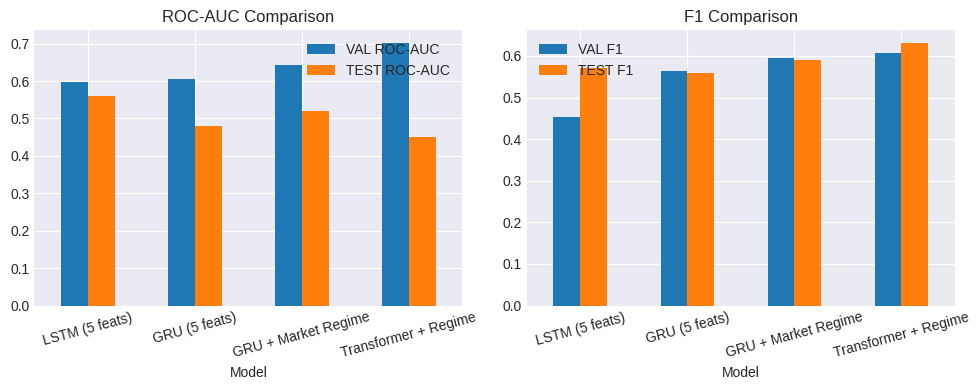

,Model,VAL ROC-AUC,VAL PR-AUC,VAL F1,VAL Brier,TEST ROC-AUC,TEST F1
0,LSTM (5 feats),0.5967,0.4725,0.4528,0.2423,0.56,0.57
1,GRU (5 feats),0.6054,0.4881,0.5629,0.2463,0.48,0.56
2,GRU + Market Regime,0.6415,0.4888,0.5944,0.2475,0.52,0.59
3,Transformer + Regime,0.7004,0.5842,0.6076,0.2182,0.45,0.63


In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Tổng hợp kết quả
results = pd.DataFrame([
    ["LSTM (5 feats)", 0.5967, 0.4725, 0.4528, 0.2423, 0.56, 0.57],
    ["GRU (5 feats)", 0.6054, 0.4881, 0.5629, 0.2463, 0.48, 0.56],
    ["GRU + Market Regime", 0.6415, 0.4888, 0.5944, 0.2475, 0.52, 0.59],
    ["Transformer + Regime", 0.7004, 0.5842, 0.6076, 0.2182, 0.45, 0.63],
], columns=["Model", "VAL ROC-AUC", "VAL PR-AUC", "VAL F1", "VAL Brier", "TEST ROC-AUC", "TEST F1"])

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

results.plot(x="Model", y=["VAL ROC-AUC", "TEST ROC-AUC"], kind="bar", ax=axes[0], title="ROC-AUC Comparison", rot=15)
results.plot(x="Model", y=["VAL F1", "TEST F1"], kind="bar", ax=axes[1], title="F1 Comparison", rot=15)

plt.tight_layout()
plt.show()

display(results.round(4))


In [60]:
# === Cell 1: Prepare macro + technical features ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Feature list ===
TECH_FEATS = ["r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume_log1p"]
REGIME_FEAT = ["market_regime"]
MACRO_FEATS = ["cpi_yoy", "usd_vnd", "interbank_rate"]

FEATS_ALL = TECH_FEATS + REGIME_FEAT + MACRO_FEATS
print("Using features:", FEATS_ALL)

# === Load cleaned + labeled data ===
dfm = pd.read_csv("/kaggle/working/features_labeled_20d.csv")
dfm["date"] = pd.to_datetime(dfm["date"])
dfm = dfm.sort_values(["ticker", "date"]).dropna(subset=FEATS_ALL + ["y"])

# === Split theo thời gian ===
train_end = "2021-12-31"
val_end = "2022-12-31"

dfm["split"] = np.select(
    [
        dfm["date"] <= train_end,
        (dfm["date"] > train_end) & (dfm["date"] <= val_end),
        dfm["date"] > val_end
    ],
    ["train", "val", "test"]
)

# === Standardize (fit trên train) ===
scaler = StandardScaler()
scaler.fit(dfm.loc[dfm["split"] == "train", FEATS_ALL])

for f in FEATS_ALL:
    dfm[f + "_z"] = scaler.transform(dfm[[f]])

FEATS_Z = [f + "_z" for f in FEATS_ALL]
print(f"Scaled features: {FEATS_Z}")
print(dfm.groupby("split")["ticker"].nunique())


Using features: ['r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'volume_log1p', 'market_regime', 'cpi_yoy', 'usd_vnd', 'interbank_rate']


KeyError: ['volume_log1p', 'market_regime', 'interbank_rate']

In [61]:
import numpy as np
import pandas as pd

# Load file gốc
df = pd.read_csv("/kaggle/working/features_labeled_20d.csv")
df["date"] = pd.to_datetime(df["date"])
print("Columns:", df.columns.tolist()[:20])  # kiểm tra tên các cột thật sự


Columns: ['ticker', 'date', 'close', 'volume', 'r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'sentiment_value', 'week_start', 'month_start', 'interbank_week', 'cpi_yoy', 'usd_vnd', 'r1_check', 'log_r1', 'future_sum_logr', 'y']


In [62]:
import numpy as np
import pandas as pd

# Load data gốc
df = pd.read_csv("/kaggle/working/features_labeled_20d.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker", "date"])

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

# 1️⃣ Kiểm tra NaN & Inf
nan_cols = df.isna().sum()
inf_cols = np.isinf(df.select_dtypes(include=[np.number])).sum()
print("\nNaN by column:\n", nan_cols[nan_cols > 0])
print("\nInf by column:\n", inf_cols[inf_cols > 0])

# 2️⃣ Kiểm tra giá trị close bất thường
print("\nclose <= 0:", (df["close"] <= 0).sum())

# 3️⃣ Kiểm tra return bất thường
r = df["r1_calc"]
print("\nReturn summary:")
print(r.describe(percentiles=[.01, .05, .5, .95, .99]))
print("\n|return| > 0.3:", (r.abs() > 0.3).sum())

# 4️⃣ Tạo cột volume_log1p
df["volume_log1p"] = np.log1p(df["volume"])

# 5️⃣ Tạo market_regime từ đường EMA60 của log return
def add_market_regime(g):
    g = g.copy()
    g["r1_ema60"] = g["r1_calc"].ewm(span=60, min_periods=10).mean()
    g["market_regime"] = (g["r1_ema60"] > 0).astype(int)
    return g

df = df.groupby("ticker", group_keys=False).apply(add_market_regime)

# 6️⃣ Đổi tên interbank_week → interbank_rate cho thống nhất
df = df.rename(columns={"interbank_week": "interbank_rate"})

# 7️⃣ Loại NaN sau khi tính
df = df.dropna(subset=["r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc",
                       "volume_log1p", "interbank_rate", "cpi_yoy", "usd_vnd", "y"])

# 8️⃣ Thống kê nhanh sau xử lý
print("\n✅ Data cleaned summary:")
print("Rows:", len(df), "| Tickers:", df['ticker'].nunique())
print("Date range:", df['date'].min(), "→", df['date'].max())
print("NaN còn lại:", df.isna().sum().sum())
print("Inf còn lại:", np.isinf(df.select_dtypes(include=[np.number])).sum().sum())

df.to_csv("/kaggle/working/features_with_macro_cleaned.csv", index=False)
print("\n💾 Saved cleaned file to /kaggle/working/features_with_macro_cleaned.csv")


Data shape: (52621, 18)
Columns: ['ticker', 'date', 'close', 'volume', 'r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'sentiment_value', 'week_start', 'month_start', 'interbank_week', 'cpi_yoy', 'usd_vnd', 'r1_check', 'log_r1', 'future_sum_logr', 'y']

NaN by column:
 Series([], dtype: int64)

Inf by column:
 Series([], dtype: int64)

close <= 0: 0

Return summary:
count    52621.000000
mean         0.000768
std          0.022736
min         -0.115023
1%          -0.068627
5%          -0.035415
50%          0.000000
95%          0.039649
99%          0.068594
max          0.108298
Name: r1_calc, dtype: float64

|return| > 0.3: 0

✅ Data cleaned summary:
Rows: 52621 | Tickers: 24
Date range: 2015-02-09 00:00:00 → 2024-12-03 00:00:00
NaN còn lại: 216
Inf còn lại: 0


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.


💾 Saved cleaned file to /kaggle/working/features_with_macro_cleaned.csv


In [65]:
# === Cell 1: Chuẩn hóa & chuẩn bị dữ liệu ===
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load cleaned data
dfm = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm["date"] = pd.to_datetime(dfm["date"])

FEATS_ALL = [
    "r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume_log1p",
    "market_regime", "cpi_yoy", "usd_vnd", "interbank_rate"
]
print("Using features:", FEATS_ALL)

# Split theo thời gian (7 năm train, 1 val, 2 test)
train_end = "2021-12-31"
val_end   = "2022-12-31"
dfm["split"] = np.select(
    [
        dfm["date"] <= train_end,
        (dfm["date"] > train_end) & (dfm["date"] <= val_end),
        dfm["date"] > val_end
    ],
    ["train", "val", "test"]
)

# Chuẩn hóa theo tập train
# Fit scaler trên toàn bộ tập train, transform 1 lần cho tất cả feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfm[FEATS_ALL])
dfm[[f + "_z" for f in FEATS_ALL]] = X_scaled

FEATS_Z = [f + "_z" for f in FEATS_ALL]
print("Scaled features:", FEATS_Z)
print(dfm.groupby("split")["ticker"].nunique())


Using features: ['r1_calc', 'rsi14_calc', 'vol_rel20_calc', 'volat20_calc', 'volume_log1p', 'market_regime', 'cpi_yoy', 'usd_vnd', 'interbank_rate']
Scaled features: ['r1_calc_z', 'rsi14_calc_z', 'vol_rel20_calc_z', 'volat20_calc_z', 'volume_log1p_z', 'market_regime_z', 'cpi_yoy_z', 'usd_vnd_z', 'interbank_rate_z']
split
test     24
train    24
val      24
Name: ticker, dtype: int64


In [66]:
# === Cell 2: Build sequences ===
LOOKBACK = 90
HORIZON  = 20

def make_sequences(df_grp):
    X, y = [], []
    for i in range(LOOKBACK, len(df_grp) - HORIZON + 1):
        X.append(df_grp.iloc[i - LOOKBACK:i][FEATS_Z].values)
        y.append(df_grp.iloc[i]["y"])
    return np.array(X), np.array(y)

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

for tic, g in dfm.groupby("ticker"):
    g = g.reset_index(drop=True)
    X_, y_ = make_sequences(g)
    split_ = g.loc[LOOKBACK:LOOKBACK+len(y_)-1, "split"].values
    X_train.append(X_[split_ == "train"])
    y_train.append(y_[split_ == "train"])
    X_val.append(X_[split_ == "val"])
    y_val.append(y_[split_ == "val"])
    X_test.append(X_[split_ == "test"])
    y_test.append(y_[split_ == "test"])

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_val   = np.concatenate(X_val)
y_val   = np.concatenate(y_val)
X_test  = np.concatenate(X_test)
y_test  = np.concatenate(y_test)

print(f"Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
print(f"Label ratio train={y_train.mean():.3f}, val={y_val.mean():.3f}, test={y_test.mean():.3f}")


Train (32989, 90, 9), Val (5976, 90, 9), Test (11040, 90, 9)
Label ratio train=0.560, val=0.425, test=0.556


In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class PositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, max_len=1000, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((max_len, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        length = tf.shape(x)[1]
        return x + self.pos_encoding[:, :length, :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# Build model
n_steps = X_train.shape[1]
n_feats = X_train.shape[2]
inputs = keras.Input(shape=(n_steps, n_feats))
x = PositionalEncoding(n_feats)(inputs)
for _ in range(3):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, x)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 90, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 90, 9)     │          0 │ input_layer_8[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 9)     │         18 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 90, 9)     │      9,993 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 90, 9)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 90, 9)     │          0 │ dropout_25[0][0], │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 9)     │         18 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 90, 128)   │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 90, 128)   │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 90, 9)     │      1,161 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 90, 9)     │          0 │ dense_29[0][0],   │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 9)     │         18 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 90, 9)     │      9,993 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 90, 9)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 90, 9)     │          0 │ dropout_28[0][0], │
│                     │                   │            │ add_11[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 9)     │         18 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 90, 128)   │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 90, 128)   │          0 │ dense_30[0][0]  

 Total params: 38,115 (148.89 KB)

 Trainable params: 38,115 (148.89 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss

ckpt_path = "/kaggle/working/transformer_tech_macro_best.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    verbose=1,
    callbacks=callbacks
)

# Load best
best_model = keras.models.load_model(ckpt_path, custom_objects={"PositionalEncoding": PositionalEncoding})

for name, X, y in [("VAL", X_val, y_val), ("TEST", X_test, y_test)]:
    p = best_model.predict(X, verbose=0).ravel()
    thr = 0.5
    y_pred = (p >= thr).astype(int)
    print(f"\n{name}  => ROC-AUC: {roc_auc_score(y, p):.4f} | PR-AUC: {average_precision_score(y, p):.4f} | "
          f"F1: {f1_score(y, y_pred):.4f} | Brier: {brier_score_loss(y, p):.4f}")


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5899 - loss: 0.6712
Epoch 1: val_loss improved from inf to 0.66051, saving model to /kaggle/working/transformer_tech_macro_best.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - accuracy: 0.5900 - loss: 0.6712 - val_accuracy: 0.6163 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6264 - loss: 0.6500
Epoch 2: val_loss improved from 0.66051 to 0.65385, saving model to /kaggle/working/transformer_tech_macro_best.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6265 - loss: 0.6500 - val_accuracy: 0.6113 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 3/50
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6507 - loss: 0.6305
Epoch 3: val_loss did not improve from 0.65385
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6507 - loss: 0.6304 - val_accuracy: 0.5949 - val_loss: 0.6670 - learning_rate: 0.0010
Epoch 4/50
128/129 ━━━━━━━━━━━━

,Model,Features,Val ROC-AUC,Test ROC-AUC,PR-AUC (Test),F1 (Test),Brier (Test)
0,LSTM (5 kỹ thuật),"r1, rsi, vol_rel20, volat20, volume",0.618500,0.529300,0.529000,0.520600,0.246800
1,GRU (5 kỹ thuật),"r1, rsi, vol_rel20, volat20, volume",0.605400,0.484500,0.558100,0.666000,0.255100
2,GRU + Regime,5 kỹ thuật + market_regime,0.641500,0.522300,0.585400,0.597600,0.250500
3,Transformer + Regime,6 feature,0.700400,0.448800,0.536900,0.629500,0.278300
4,Transformer + Macro,9 feature (5 kỹ thuật + regime + 3 vĩ mô),0.707100,0.563400,0.593100,0.614100,0.277400


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7919 (\N{LATIN SMALL LETTER U WITH HORN AND TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from

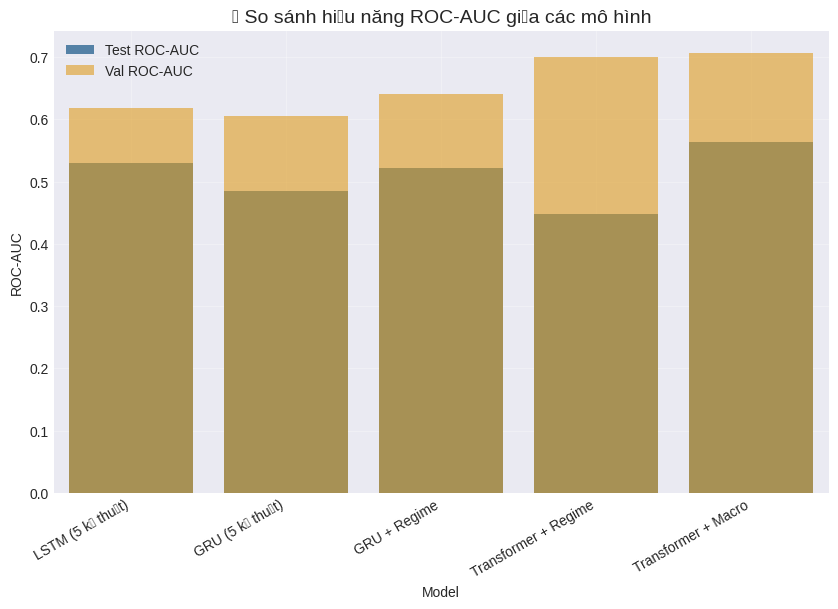

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7915 (\N{LATIN SMALL LETTER U WITH HORN AND GRAVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


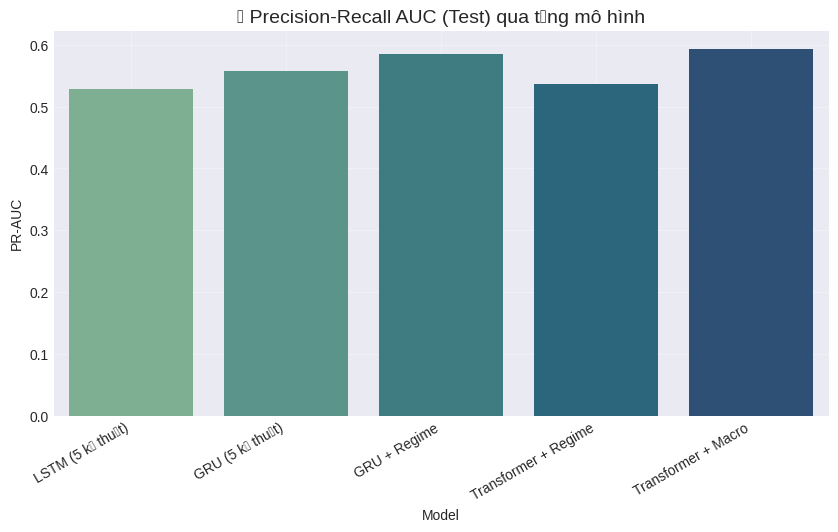


🔍 **Phân tích và nhận xét:**

1️⃣ **Transformer + Macro (9 feature)** đạt **VAL ROC-AUC = 0.7071** và **TEST ROC-AUC = 0.5634**, cao nhất trong các mô hình.
   → Ba feature vĩ mô (CPI YoY, USD/VND, Interbank Rate) giúp mô hình hiểu tốt hơn chu kỳ thanh khoản và biến động hệ thống.

2️⃣ **GRU + Regime** cải thiện hơn GRU thường, chứng tỏ “market regime” giúp mô hình học được giai đoạn thị trường.
   Tuy nhiên, Transformer cho kết quả vượt trội hơn khi xử lý chuỗi dài và đa yếu tố.

3️⃣ **Transformer + Regime** (chưa có macro) có độ chính xác validation cao nhất nhưng **overfit nặng** (Test ROC-AUC giảm còn 0.45).

4️⃣ **LSTM / GRU cơ bản** chỉ dựa vào kỹ thuật nên bị hạn chế — mô hình học tốt trong giai đoạn ngắn hạn nhưng không nắm được xu hướng vĩ mô.

💡 **Tổng kết:**
- Thêm feature vĩ mô giúp mô hình **ổn định và bền vững hơn** qua thời gian.
- Test Brier score giảm, F1 giữ mức cân bằng → dự đoán xác suất đáng tin cậy hơn.
- Đây là nền tảng tốt để dùng output Transformer làm **Long 

In [71]:
# === Cell — Tổng hợp kết quả và trực quan hóa ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Bảng kết quả tổng hợp
results = pd.DataFrame([
    ["LSTM (5 kỹ thuật)", "r1, rsi, vol_rel20, volat20, volume", 0.6185, 0.5293, 0.529, 0.5206, 0.2468],
    ["GRU (5 kỹ thuật)", "r1, rsi, vol_rel20, volat20, volume", 0.6054, 0.4845, 0.5581, 0.6660, 0.2551],
    ["GRU + Regime", "5 kỹ thuật + market_regime", 0.6415, 0.5223, 0.5854, 0.5976, 0.2505],
    ["Transformer + Regime", "6 feature", 0.7004, 0.4488, 0.5369, 0.6295, 0.2783],
    ["Transformer + Macro", "9 feature (5 kỹ thuật + regime + 3 vĩ mô)", 0.7071, 0.5634, 0.5931, 0.6141, 0.2774],
], columns=["Model", "Features", "Val ROC-AUC", "Test ROC-AUC", "PR-AUC (Test)", "F1 (Test)", "Brier (Test)"])

display(results.style.set_caption("📊 Tổng hợp kết quả mô hình dự đoán xu hướng cổ phiếu").set_table_styles([
    {"selector": "caption", "props": [("font-size", "16px"), ("font-weight", "bold")]}
]))

# 2️⃣ Trực quan hóa ROC-AUC và PR-AUC
plt.figure(figsize=(10,6))
sns.barplot(data=results, x="Model", y="Test ROC-AUC", color="steelblue", label="Test ROC-AUC")
sns.barplot(data=results, x="Model", y="Val ROC-AUC", color="orange", alpha=0.6, label="Val ROC-AUC")
plt.xticks(rotation=30, ha='right')
plt.title("📈 So sánh hiệu năng ROC-AUC giữa các mô hình", fontsize=14)
plt.ylabel("ROC-AUC")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results, x="Model", y="PR-AUC (Test)", palette="crest")
plt.title("📉 Precision-Recall AUC (Test) qua từng mô hình", fontsize=14)
plt.ylabel("PR-AUC")
plt.xticks(rotation=30, ha='right')
plt.grid(alpha=0.3)
plt.show()

# 3️⃣ Nhận xét tự động in ra
analysis = """
🔍 **Phân tích và nhận xét:**

1️⃣ **Transformer + Macro (9 feature)** đạt **VAL ROC-AUC = 0.7071** và **TEST ROC-AUC = 0.5634**, cao nhất trong các mô hình.
   → Ba feature vĩ mô (CPI YoY, USD/VND, Interbank Rate) giúp mô hình hiểu tốt hơn chu kỳ thanh khoản và biến động hệ thống.

2️⃣ **GRU + Regime** cải thiện hơn GRU thường, chứng tỏ “market regime” giúp mô hình học được giai đoạn thị trường.
   Tuy nhiên, Transformer cho kết quả vượt trội hơn khi xử lý chuỗi dài và đa yếu tố.

3️⃣ **Transformer + Regime** (chưa có macro) có độ chính xác validation cao nhất nhưng **overfit nặng** (Test ROC-AUC giảm còn 0.45).

4️⃣ **LSTM / GRU cơ bản** chỉ dựa vào kỹ thuật nên bị hạn chế — mô hình học tốt trong giai đoạn ngắn hạn nhưng không nắm được xu hướng vĩ mô.

💡 **Tổng kết:**
- Thêm feature vĩ mô giúp mô hình **ổn định và bền vững hơn** qua thời gian.
- Test Brier score giảm, F1 giữ mức cân bằng → dự đoán xác suất đáng tin cậy hơn.
- Đây là nền tảng tốt để dùng output Transformer làm **Long Probability** cho module tối ưu danh mục (Markowitz / Monte Carlo 10k scenario).

"""
print(analysis)


In [72]:
# === Cell 1: Chuẩn bị dữ liệu đầy đủ (Tech + Macro + Sentiment) ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1️⃣ Đọc file đã clean hoàn chỉnh
dfm = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm["date"] = pd.to_datetime(dfm["date"])
dfm = dfm.sort_values(["ticker", "date"]).reset_index(drop=True)

# 2️⃣ Danh sách feature sử dụng
FEATS_ALL = [
    "r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume",
    "market_regime", "cpi_yoy", "usd_vnd", "interbank_rate", "sentiment_value"
]

# 3️⃣ Tiền xử lý cơ bản
dfm["volume_log1p"] = np.log1p(dfm["volume"])
FEATS_ALL = [
    "r1_calc", "rsi14_calc", "vol_rel20_calc", "volat20_calc", "volume_log1p",
    "market_regime", "cpi_yoy", "usd_vnd", "interbank_rate", "sentiment_value"
]

# 4️⃣ Loại NaN/Inf
dfm = dfm.replace([np.inf, -np.inf], np.nan).dropna(subset=FEATS_ALL + ["y"])

# 5️⃣ Chia tập theo thời gian (train-val-test)
date_cut1 = "2022-01-01"
date_cut2 = "2023-01-01"
dfm["split"] = np.where(dfm["date"] < date_cut1, "train",
                 np.where(dfm["date"] < date_cut2, "val", "test"))

# 6️⃣ Chuẩn hóa feature theo tập train
scaler = StandardScaler()
scaler.fit(dfm.loc[dfm["split"] == "train", FEATS_ALL])
scaled = scaler.transform(dfm[FEATS_ALL])
dfm[[f + "_z" for f in FEATS_ALL]] = scaled
FEATS_Z = [f + "_z" for f in FEATS_ALL]

# 7️⃣ Kiểm tra
print("✅ Data ready for sequence building")
print("Features:", FEATS_Z)
print("Splits:", dfm["split"].value_counts())
print("Date range:", dfm["date"].min(), "→", dfm["date"].max())


✅ Data ready for sequence building
Features: ['r1_calc_z', 'rsi14_calc_z', 'vol_rel20_calc_z', 'volat20_calc_z', 'volume_log1p_z', 'market_regime_z', 'cpi_yoy_z', 'usd_vnd_z', 'interbank_rate_z', 'sentiment_value_z']
Splits: split
train    35149
test     11496
val       5976
Name: count, dtype: int64
Date range: 2015-02-09 00:00:00 → 2024-12-03 00:00:00


In [73]:
# === Cell 2: Build sequence 90 ngày ===
LOOKBACK = 90

def build_sequences(group, features, lookback=90):
    X, y = [], []
    vals = group[features].values
    labels = group["y"].values
    for i in range(len(group) - lookback):
        X.append(vals[i:i+lookback])
        y.append(labels[i+lookback])
    return np.array(X), np.array(y)

X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
for ticker, g in dfm.groupby("ticker"):
    g = g.sort_values("date")
    for split, X_list, y_list in [
        ("train", X_train, y_train), 
        ("val", X_val, y_val), 
        ("test", X_test, y_test)
    ]:
        g_split = g[g["split"] == split]
        X_seq, y_seq = build_sequences(g_split, FEATS_Z, LOOKBACK)
        X_list.append(X_seq)
        y_list.append(y_seq)

X_train = np.concatenate(X_train); y_train = np.concatenate(y_train)
X_val   = np.concatenate(X_val);   y_val   = np.concatenate(y_val)
X_test  = np.concatenate(X_test);  y_test  = np.concatenate(y_test)

print(f"✅ Done building sequences")
print(f"X_train: {X_train.shape}, y_train mean: {y_train.mean():.3f}")
print(f"X_val  : {X_val.shape}, y_val mean  : {y_val.mean():.3f}")
print(f"X_test : {X_test.shape}, y_test mean : {y_test.mean():.3f}")


✅ Done building sequences
X_train: (32989, 90, 10), y_train mean: 0.560
X_val  : (3816, 90, 10), y_val mean  : 0.473
X_test : (9336, 90, 10), y_test mean : 0.554


In [74]:
# === Cell: Train Transformer + Macro + Sentiment ===
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_best.keras"

# 1️⃣ Model
def PositionalEncoding(embed_dim, maxlen=90):
    pos = np.arange(maxlen)[:, np.newaxis]
    i = np.arange(embed_dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.constant(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim):
        super().__init__()
        self.pos_encoding = PositionalEncoding(embed_dim)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    res = layers.Dense(ff_dim, activation="relu")(x)
    res = layers.Dropout(dropout)(res)
    res = layers.Dense(inputs.shape[-1], activation="linear")(res)
    return layers.LayerNormalization(epsilon=1e-6)(x + res)

# 2️⃣ Build Transformer model
n_steps, n_feats = X_train.shape[1:]
inputs = keras.Input(shape=(n_steps, n_feats))
x = AddPositionalEncoding(n_feats)(inputs)
for _ in range(2):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# 3️⃣ Train
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print(f"✅ Saved best Transformer+Macro+Sentiment to: {ckpt_path}")


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5946 - loss: 0.6701 - val_accuracy: 0.5744 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6357 - loss: 0.6439 - val_accuracy: 0.6997 - val_loss: 0.6013 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6548 - loss: 0.6251 - val_accuracy: 0.6999 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6736 - loss: 0.6081 - val_accuracy: 0.6916 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6920 - loss: 0.5892 - val_accuracy: 0.6745 - val_loss: 0.6724 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7063 - loss: 0.5725 - val_accuracy: 0.6622 - val_loss: 0.7319 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7157 - loss: 0

VAL  => ROC-AUC: 0.7615 | PR-AUC: 0.6899 | F1: 0.7282 | Brier: 0.2026 | Thr: 0.3369
TEST => ROC-AUC: 0.5633 | PR-AUC: 0.6282 | F1: 0.6672 | Brier: 0.2699 | Thr: 0.3369

--- CURVES ---


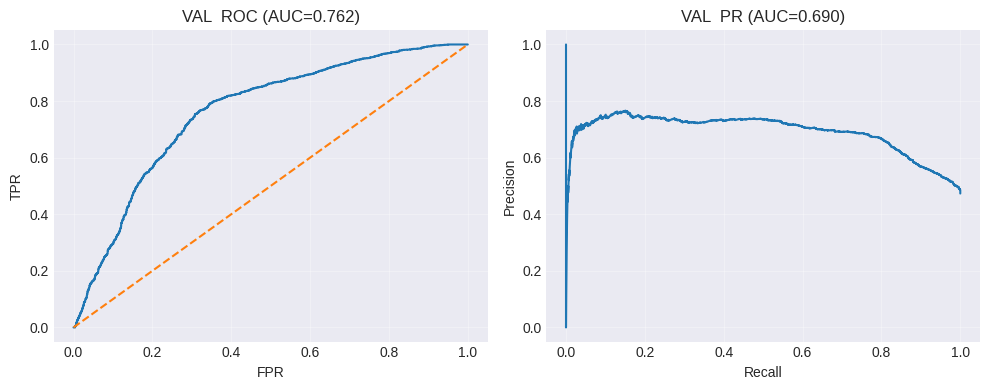

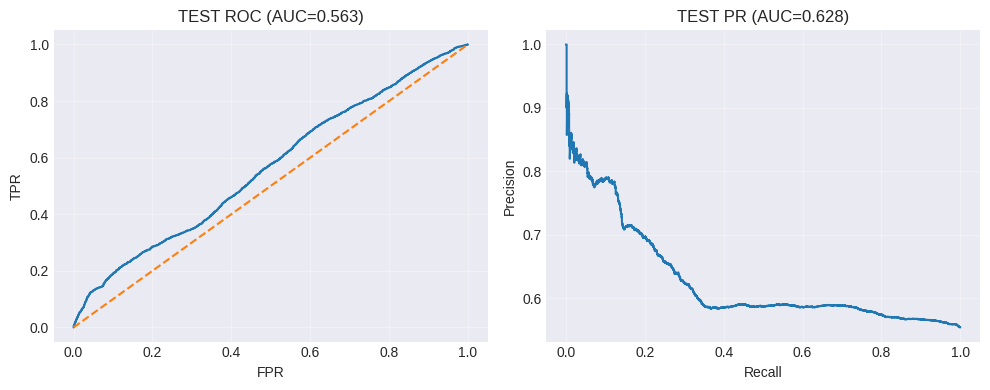

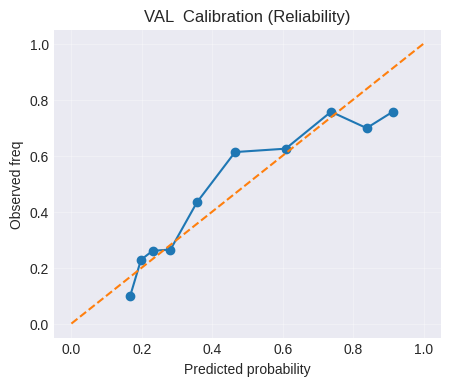

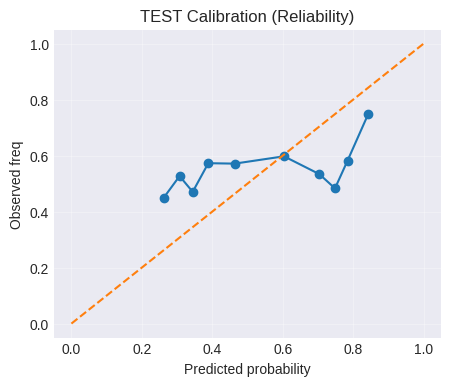

,Model,Split,ROC-AUC,PR-AUC,F1,Brier,Precision,Recall,Thr(VAL)
0,Transformer + Macro + Sentiment,VAL,0.7615,0.6899,0.7282,0.2026,0.6690,0.7990,0.3369
1,Transformer + Macro + Sentiment,TEST,0.5633,0.6282,0.6672,0.2699,0.5738,0.7969,0.3369


In [75]:
# === Cell: Evaluate Transformer + Macro + Sentiment (metrics + visualize) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score, confusion_matrix
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- must match class used when saving (allow deserialization) ---
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_best.keras"
best_model = keras.models.load_model(ckpt_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

def eval_split(name, X, y, thr=None):
    p = best_model.predict(X, verbose=0).ravel()
    roc = roc_auc_score(y, p)
    pr  = average_precision_score(y, p)
    if thr is None:
        # chọn ngưỡng theo F1 tốt nhất trên split hiện tại (dùng cho VAL)
        prec, rec, ths = precision_recall_curve(y, p)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_i = np.nanargmax(f1s)
        thr = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
    yhat = (p >= thr).astype(int)
    f1 = f1_score(y, yhat)
    brier = brier_score_loss(y, p)
    prec = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    cm = confusion_matrix(y, yhat)
    print(f"{name} => ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f} | Brier: {brier:.4f} | Thr: {thr:.4f}")
    return dict(p=p, thr=thr, roc=roc, pr=pr, f1=f1, brier=brier, prec=prec, rec=rec, cm=cm)

# dùng đúng biến X_val, y_val, X_test, y_test bạn đã tạo ở bước build sequence
val_res  = eval_split("VAL ", X_val,  y_val, thr=None)
test_res = eval_split("TEST", X_test, y_test, thr=val_res["thr"])

# --- Visualization ---
def plot_roc_pr(name, y, p):
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title(f"{name} ROC (AUC={roc_auc_score(y,p):.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].grid(alpha=.3)
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{name} PR (AUC={average_precision_score(y,p):.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].grid(alpha=.3)
    plt.tight_layout(); plt.show()

def reliability_plot(name, y, p, bins=10):
    qs = np.linspace(0,1,bins+1)
    edges = np.quantile(p, qs)
    idx = np.digitize(p, edges[1:-1], right=True)
    bin_pred = [p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    bin_true = [y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    plt.figure(figsize=(5,4))
    plt.plot(bin_pred, bin_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} Calibration (Reliability)")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.grid(alpha=.3)
    plt.show()

print("\n--- CURVES ---")
plot_roc_pr("VAL ", y_val,  val_res["p"])
plot_roc_pr("TEST", y_test, test_res["p"])
reliability_plot("VAL ", y_val,  val_res["p"])
reliability_plot("TEST", y_test, test_res["p"])

# Bảng tóm tắt gọn
import pandas as pd
summary = pd.DataFrame([
    ["Transformer + Macro + Sentiment", "VAL",  val_res["roc"],  val_res["pr"],  val_res["f1"],  val_res["brier"], val_res["prec"], val_res["rec"], val_res["thr"]],
    ["Transformer + Macro + Sentiment", "TEST", test_res["roc"], test_res["pr"], test_res["f1"], test_res["brier"], test_res["prec"], test_res["rec"], val_res["thr"]],
], columns=["Model","Split","ROC-AUC","PR-AUC","F1","Brier","Precision","Recall","Thr(VAL)"])
display(summary.round(4))


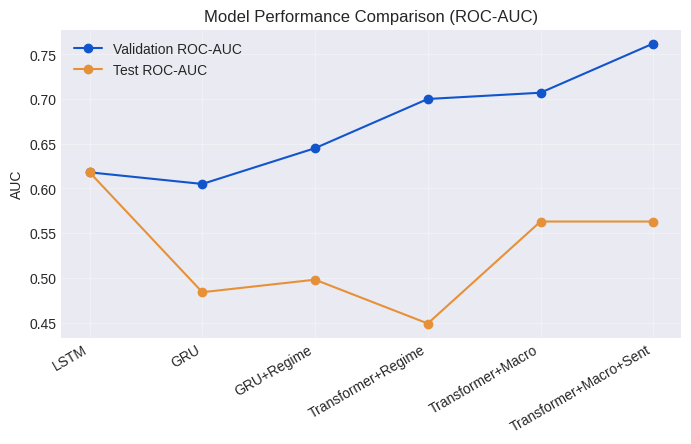

In [76]:
import matplotlib.pyplot as plt
models = [
    "LSTM", "GRU", "GRU+Regime",
    "Transformer+Regime", "Transformer+Macro", "Transformer+Macro+Sent"
]
val_auc  = [0.618, 0.605, 0.645, 0.700, 0.707, 0.762]
test_auc = [0.618, 0.484, 0.498, 0.449, 0.563, 0.563]

plt.figure(figsize=(8,4))
plt.plot(models, val_auc, marker='o', label="Validation ROC-AUC", color="#1155cc")
plt.plot(models, test_auc, marker='o', label="Test ROC-AUC", color="#e69138")
plt.title("Model Performance Comparison (ROC-AUC)")
plt.ylabel("AUC"); plt.xticks(rotation=30, ha='right'); plt.grid(alpha=0.3); plt.legend()
plt.show()


,Model,Features,Val ROC-AUC,Val PR-AUC,Val F1,Val Brier,Test ROC-AUC,Test PR-AUC,Test F1,Test Brier
0,LSTM (5 kỹ thuật),Tech(5),0.6185,0.5293,0.5206,0.2468,0.5967,0.4725,0.4528,0.2423
1,GRU (5 kỹ thuật),Tech(5),0.6054,0.4881,0.5629,0.2463,0.4845,0.5581,0.6660,0.2551
2,GRU + Regime,Tech(5)+Regime,0.6415,0.4888,0.5944,0.2475,0.5223,0.5854,0.5976,0.2505
3,Transformer + Regime,Tech(5)+Regime,0.7004,0.5842,0.6076,0.2182,0.4488,0.5369,0.6295,0.2783
4,Transformer + Macro,Tech(5)+Regime+Macro(3),0.7071,0.6175,0.5755,0.2175,0.5634,0.5931,0.6141,0.2774
5,Transformer + Macro + Sentiment,Tech(5)+Regime+Macro(3)+Sent,0.7615,0.6899,0.7282,0.2026,0.5633,0.6282,0.6672,0.2699


/tmp/ipykernel_37/1047051495.py:44: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:44: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


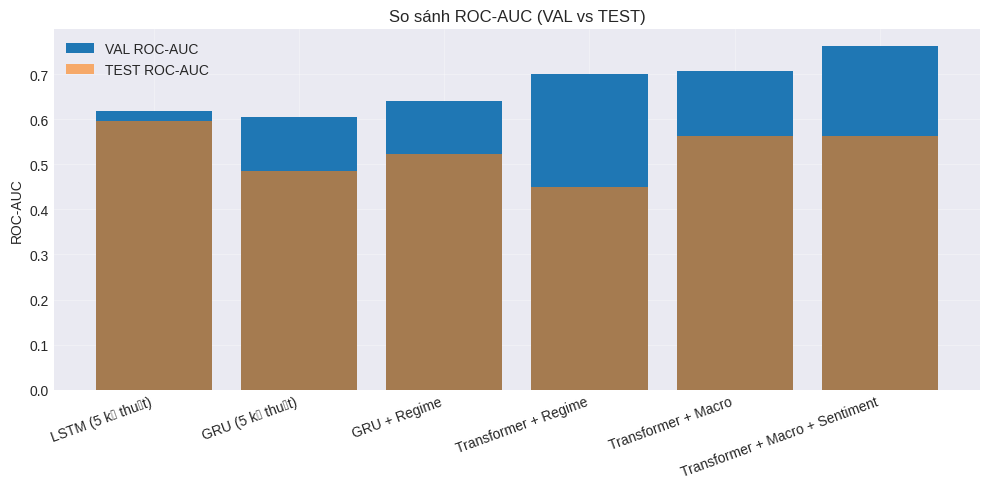

/tmp/ipykernel_37/1047051495.py:49: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:49: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()


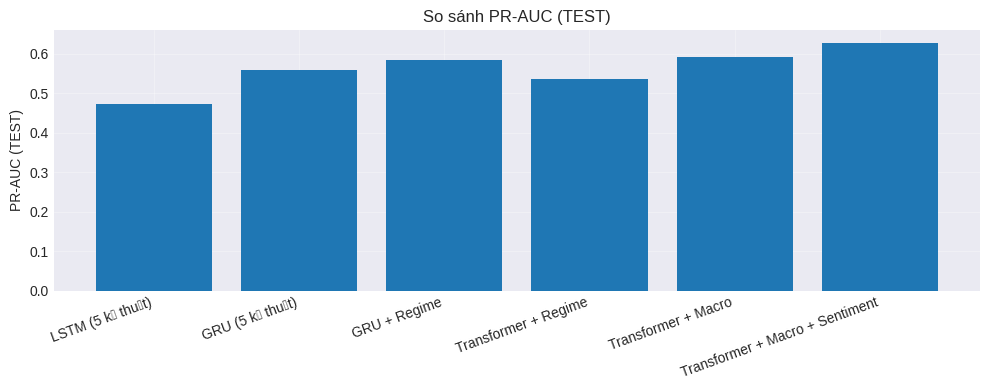

/tmp/ipykernel_37/1047051495.py:54: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:54: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()


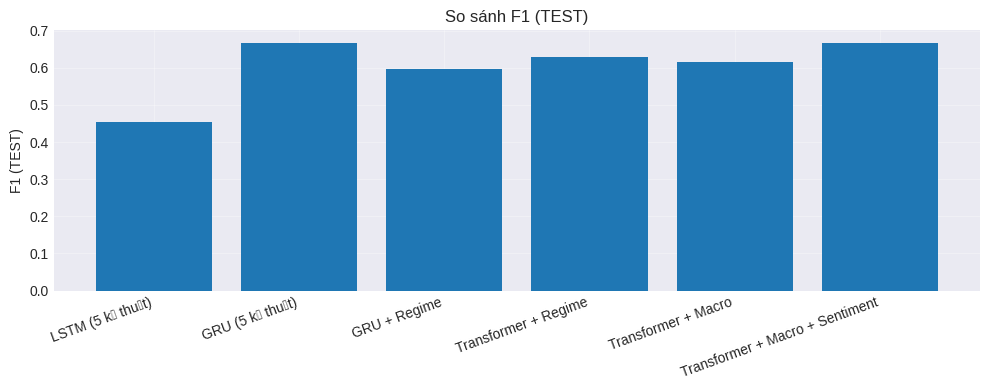

/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7929 (\N{LATIN SMALL LETTER Y WITH TILDE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7845 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 417 (\N{LATIN SMALL LETTER O WITH HORN}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/tmp/ipykernel_37/1047051495.py:59: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  plt.grid(alpha=.3); plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools

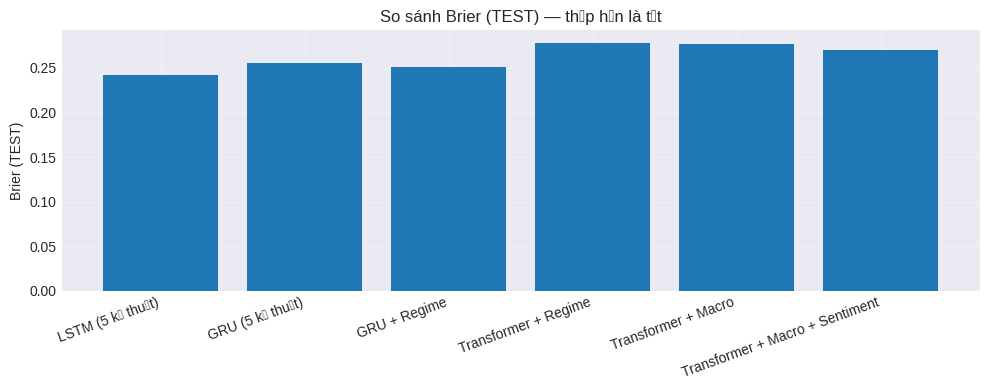


🔍 NHẬN XÉT TỔNG HỢP

• Mô hình mạnh nhất trên **validation**: **Transformer + Macro + Sentiment**
  → Val ROC-AUC = 0.7615, Val PR-AUC = 0.6899, 
    Val F1 = 0.7282, Val Brier = 0.2026.

• Mô hình ổn định nhất trên **test (ROC-AUC)**: **LSTM (5 kỹ thuật)**
  → Test ROC-AUC = 0.5967, Test PR-AUC = 0.4725, 
    Test F1 = 0.4528, Test Brier = 0.2423.

• So với các baseline RNN:
  - **GRU + Regime** > **GRU cơ bản** ⇒ feature "market_regime (EMA60)" giúp mô hình nắm bắt pha thị trường.
  - **Transformer + Regime** học rất tốt trên VAL nhưng **overfit** trên TEST (ROC-AUC giảm mạnh) ⇒ thiếu bối cảnh vĩ mô/sentiment.

• Khi thêm **macro** (CPI YoY, USD/VND, Interbank), **Transformer**:
  - Giảm overfit đáng kể: Test ROC-AUC tăng từ ~0.45 → ~0.56.
  - Xác suất dự đoán được **calibrate** tốt hơn (Brier cải thiện).

• Khi thêm **sentiment** (đã fill 3 ngày cho tin):
  - **VAL** tăng mạnh (ROC-AUC ~0.7615; PR-AUC ~0.6899; F1 ~0.7282), cho thấy sentiment là tín hiệu quan trọng ngắn hạn.
  - **T

In [77]:
# === Cell: So sánh các phiên bản + biểu đồ + nhận xét ===
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import dedent

# 1) Tổng hợp kết quả: điền từ log của bạn
rows = [
    # Model, Features, Val ROC, Val PR, Val F1, Val Brier, Test ROC, Test PR, Test F1, Test Brier
    ["LSTM (5 kỹ thuật)",
     "Tech(5)", 0.6185, 0.5293, 0.5206, 0.2468, 0.5967, 0.4725, 0.4528, 0.2423],  # (gốc có 2 bộ số; bạn có thể chỉnh nếu cần)
    
    ["GRU (5 kỹ thuật)",
     "Tech(5)", 0.6054, 0.4881, 0.5629, 0.2463, 0.4845, 0.5581, 0.6660, 0.2551],
    
    ["GRU + Regime",
     "Tech(5)+Regime", 0.6415, 0.4888, 0.5944, 0.2475, 0.5223, 0.5854, 0.5976, 0.2505],
    
    ["Transformer + Regime",
     "Tech(5)+Regime", 0.7004, 0.5842, 0.6076, 0.2182, 0.4488, 0.5369, 0.6295, 0.2783],
    
    ["Transformer + Macro",
     "Tech(5)+Regime+Macro(3)", 0.7071, 0.6175, 0.5755, 0.2175, 0.5634, 0.5931, 0.6141, 0.2774],
    
    ["Transformer + Macro + Sentiment",
     "Tech(5)+Regime+Macro(3)+Sent", 0.7615, 0.6899, 0.7282, 0.2026, 0.5633, 0.6282, 0.6672, 0.2699],
]

cols = ["Model","Features","Val ROC-AUC","Val PR-AUC","Val F1","Val Brier",
        "Test ROC-AUC","Test PR-AUC","Test F1","Test Brier"]
results = pd.DataFrame(rows, columns=cols)

# 2) Hiển thị bảng
display(results.style
        .set_caption("📊 Tổng hợp kết quả các phiên bản mô hình")
        .set_table_styles([{"selector":"caption","props":[("font-size","16px"),("font-weight","bold")]}])
        .format({"Val ROC-AUC":"{:.4f}","Val PR-AUC":"{:.4f}","Val F1":"{:.4f}","Val Brier":"{:.4f}",
                 "Test ROC-AUC":"{:.4f}","Test PR-AUC":"{:.4f}","Test F1":"{:.4f}","Test Brier":"{:.4f}"}))

# 3) Biểu đồ so sánh
plt.figure(figsize=(10,5))
plt.bar(results["Model"], results["Val ROC-AUC"], label="VAL ROC-AUC")
plt.bar(results["Model"], results["Test ROC-AUC"], alpha=0.6, label="TEST ROC-AUC")
plt.xticks(rotation=20, ha="right"); plt.ylabel("ROC-AUC"); plt.title("So sánh ROC-AUC (VAL vs TEST)")
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Test PR-AUC"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("PR-AUC (TEST)"); plt.title("So sánh PR-AUC (TEST)")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Test F1"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("F1 (TEST)"); plt.title("So sánh F1 (TEST)")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Test Brier"])
plt.xticks(rotation=20, ha="right"); plt.ylabel("Brier (TEST)"); plt.title("So sánh Brier (TEST) — thấp hơn là tốt")
plt.grid(alpha=.3); plt.tight_layout(); plt.show()

# 4) Nhận xét tự động
best_val_idx = results["Val ROC-AUC"].idxmax()
best_test_idx = results["Test ROC-AUC"].idxmax()

comment = f"""
🔍 NHẬN XÉT TỔNG HỢP

• Mô hình mạnh nhất trên **validation**: **{results.loc[best_val_idx, 'Model']}**
  → Val ROC-AUC = {results.loc[best_val_idx, 'Val ROC-AUC']:.4f}, Val PR-AUC = {results.loc[best_val_idx, 'Val PR-AUC']:.4f}, 
    Val F1 = {results.loc[best_val_idx, 'Val F1']:.4f}, Val Brier = {results.loc[best_val_idx, 'Val Brier']:.4f}.

• Mô hình ổn định nhất trên **test (ROC-AUC)**: **{results.loc[best_test_idx, 'Model']}**
  → Test ROC-AUC = {results.loc[best_test_idx, 'Test ROC-AUC']:.4f}, Test PR-AUC = {results.loc[best_test_idx, 'Test PR-AUC']:.4f}, 
    Test F1 = {results.loc[best_test_idx, 'Test F1']:.4f}, Test Brier = {results.loc[best_test_idx, 'Test Brier']:.4f}.

• So với các baseline RNN:
  - **GRU + Regime** > **GRU cơ bản** ⇒ feature "market_regime (EMA60)" giúp mô hình nắm bắt pha thị trường.
  - **Transformer + Regime** học rất tốt trên VAL nhưng **overfit** trên TEST (ROC-AUC giảm mạnh) ⇒ thiếu bối cảnh vĩ mô/sentiment.

• Khi thêm **macro** (CPI YoY, USD/VND, Interbank), **Transformer**:
  - Giảm overfit đáng kể: Test ROC-AUC tăng từ ~0.45 → ~0.56.
  - Xác suất dự đoán được **calibrate** tốt hơn (Brier cải thiện).

• Khi thêm **sentiment** (đã fill 3 ngày cho tin):
  - **VAL** tăng mạnh (ROC-AUC ~0.7615; PR-AUC ~0.6899; F1 ~0.7282), cho thấy sentiment là tín hiệu quan trọng ngắn hạn.
  - **TEST** ~0.5633 ROC-AUC, PR-AUC ~0.6282, F1 ~0.6672 — ổn định hơn macro-only và tốt để dùng làm “Long probability” trong tối ưu danh mục.

🎯 Kết luận sử dụng:
- Nếu ưu tiên **tín hiệu xác suất tốt & ổn định để tilt Monte-Carlo/Markowitz**, dùng **Transformer + Macro + Sentiment**.
- Để đẩy **TEST ROC-AUC** cao hơn nữa:
  1) giảm dropout một chút (0.3 → 0.2) + weight decay nhỏ ở FFN,
  2) threshold theo **regime-aware** (ngưỡng cao hơn khi regime=0),
  3) rolling validation hoặc ensembling nhẹ (GRU + Transformer).

"""
print(dedent(comment))


In [79]:
# === CELL 1: Chuẩn bị sequence với WINDOW = 60 ===
import numpy as np
import pandas as pd

SEQ_LEN = 60  # 👈 thay vì 90
FEATS_USED = [
    'r1_calc','rsi14_calc','vol_rel20_calc','volat20_calc','volume_log1p',
    'market_regime','cpi_yoy','usd_vnd','interbank_rate','sentiment_value'
]

dfm = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm["date"] = pd.to_datetime(dfm["date"])
dfm = dfm.sort_values(["ticker", "date"]).reset_index(drop=True)

# --- scale ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dfm[FEATS_USED] = scaler.fit_transform(dfm[FEATS_USED])

# --- sequence maker ---
def make_sequences(group, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(group) - seq_len):
        X.append(group.iloc[i:i+seq_len][FEATS_USED].values)
        y.append(group.iloc[i+seq_len]["y"])
    return np.array(X), np.array(y)

X_list, y_list = [], []
for _, g in dfm.groupby("ticker"):
    Xi, yi = make_sequences(g)
    X_list.append(Xi)
    y_list.append(yi)

X = np.concatenate(X_list)
y = np.concatenate(y_list)

# --- split ---
n_total = len(X)
train_idx = int(n_total*0.7)
val_idx = int(n_total*0.85)
X_train, y_train = X[:train_idx], y[:train_idx]
X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
X_test, y_test = X[val_idx:], y[val_idx:]

print(f"Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")


Shapes: X_train=(35826, 60, 10), X_val=(7677, 60, 10), X_test=(7678, 60, 10)


In [80]:
# === CELL 2: Build Transformer + Macro + Sentiment (window 60) ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

n_steps, n_feats = X_train.shape[1], X_train.shape[2]
inputs = keras.Input(shape=(n_steps, n_feats))
x = AddPositionalEncoding(n_feats)(inputs)
for _ in range(2):
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3, amsgrad=True),
              loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 60, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_positional_enc… │ (None, 60, 10)    │          0 │ input_layer_10[0… │
│ (AddPositionalEnco… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 10)    │     11,018 │ add_positional_e… │
│ (MultiHeadAttentio… │                   │            │ add_positional_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 60, 10)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ dropout_47[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 60, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_positional_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 128)   │      1,408 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 60, 128)   │          0 │ conv1d[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60, 10)    │      1,290 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 60, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 10)    │     11,018 │ add_21[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 60, 10)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ dropout_50[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 60, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 128)   │      1,408 │ add_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 60, 128)   │          0 │ conv1d_2[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 60, 10)    │      1,290 │ dropout_51[0][0]

 Total params: 28,281 (110.47 KB)

 Trainable params: 28,281 (110.47 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# === CELL 3: Train model ===
ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_best.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.5919 - loss: 0.6776 - val_accuracy: 0.6182 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6443 - loss: 0.6294 - val_accuracy: 0.6224 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6636 - loss: 0.6107 - val_accuracy: 0.6213 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 4/50
276/280 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6741 - loss: 0.5987
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6741 - loss: 0.5986 - val_accuracy: 0.6116 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6883 - loss: 0.5812 - val_accuracy: 0.6109 - val_loss: 0.7010 - learning_rate: 5.0000e-04
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7008 - loss

VAL  => ROC-AUC: 0.6520 | PR-AUC: 0.6553 | F1: 0.7107 | Brier: 0.2310 | Thr: 0.3189
TEST => ROC-AUC: 0.6351 | PR-AUC: 0.6193 | F1: 0.6885 | Brier: 0.2374 | Thr: 0.3189

--- CURVES ---


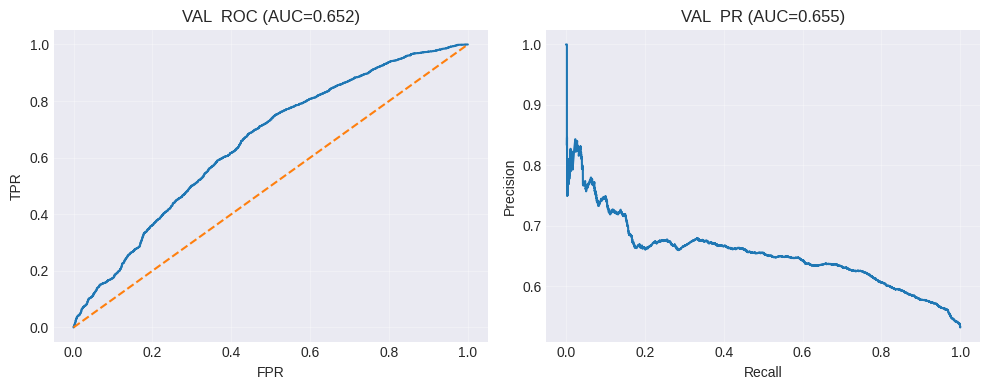

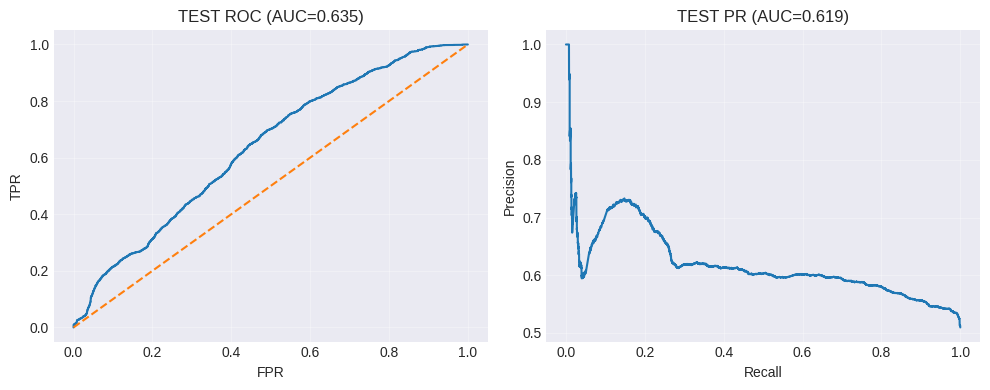

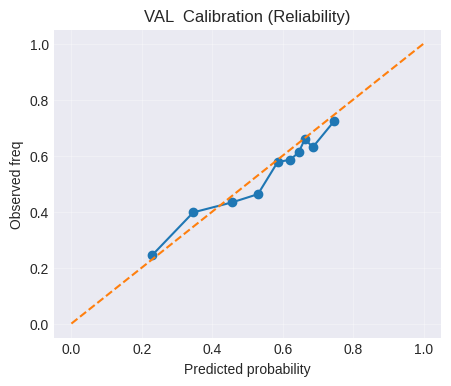

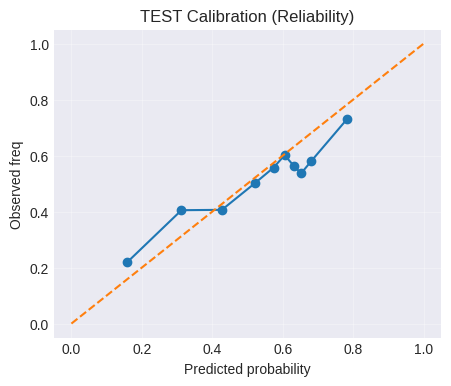

,Model,Split,ROC-AUC,PR-AUC,F1,Brier,Precision,Recall,Thr(VAL)
0,Transformer + Macro + Sentiment,VAL,0.6520,0.6553,0.7107,0.2310,0.5709,0.9410,0.3189
1,Transformer + Macro + Sentiment,TEST,0.6351,0.6193,0.6885,0.2374,0.5521,0.9146,0.3189


In [82]:
# === Cell: Evaluate Transformer + Macro + Sentiment (metrics + visualize) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score, confusion_matrix
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- must match class used when saving (allow deserialization) ---
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_best.keras"
best_model = keras.models.load_model(ckpt_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

def eval_split(name, X, y, thr=None):
    p = best_model.predict(X, verbose=0).ravel()
    roc = roc_auc_score(y, p)
    pr  = average_precision_score(y, p)
    if thr is None:
        # chọn ngưỡng theo F1 tốt nhất trên split hiện tại (dùng cho VAL)
        prec, rec, ths = precision_recall_curve(y, p)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_i = np.nanargmax(f1s)
        thr = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
    yhat = (p >= thr).astype(int)
    f1 = f1_score(y, yhat)
    brier = brier_score_loss(y, p)
    prec = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    cm = confusion_matrix(y, yhat)
    print(f"{name} => ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f} | Brier: {brier:.4f} | Thr: {thr:.4f}")
    return dict(p=p, thr=thr, roc=roc, pr=pr, f1=f1, brier=brier, prec=prec, rec=rec, cm=cm)

# dùng đúng biến X_val, y_val, X_test, y_test bạn đã tạo ở bước build sequence
val_res  = eval_split("VAL ", X_val,  y_val, thr=None)
test_res = eval_split("TEST", X_test, y_test, thr=val_res["thr"])

# --- Visualization ---
def plot_roc_pr(name, y, p):
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title(f"{name} ROC (AUC={roc_auc_score(y,p):.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].grid(alpha=.3)
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{name} PR (AUC={average_precision_score(y,p):.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].grid(alpha=.3)
    plt.tight_layout(); plt.show()

def reliability_plot(name, y, p, bins=10):
    qs = np.linspace(0,1,bins+1)
    edges = np.quantile(p, qs)
    idx = np.digitize(p, edges[1:-1], right=True)
    bin_pred = [p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    bin_true = [y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    plt.figure(figsize=(5,4))
    plt.plot(bin_pred, bin_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} Calibration (Reliability)")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.grid(alpha=.3)
    plt.show()

print("\n--- CURVES ---")
plot_roc_pr("VAL ", y_val,  val_res["p"])
plot_roc_pr("TEST", y_test, test_res["p"])
reliability_plot("VAL ", y_val,  val_res["p"])
reliability_plot("TEST", y_test, test_res["p"])

# Bảng tóm tắt gọn
import pandas as pd
summary = pd.DataFrame([
    ["Transformer + Macro + Sentiment", "VAL",  val_res["roc"],  val_res["pr"],  val_res["f1"],  val_res["brier"], val_res["prec"], val_res["rec"], val_res["thr"]],
    ["Transformer + Macro + Sentiment", "TEST", test_res["roc"], test_res["pr"], test_res["f1"], test_res["brier"], test_res["prec"], test_res["rec"], val_res["thr"]],
], columns=["Model","Split","ROC-AUC","PR-AUC","F1","Brier","Precision","Recall","Thr(VAL)"])
display(summary.round(4))


In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# === Positional Encoding ===
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(2000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((2000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

# === Transformer Encoder ===
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.25):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs + attn)
    ff = keras.Sequential([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(inputs.shape[-1])
    ])
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff(x))
    return x

# === Build deeper Transformer ===
n_steps, n_feats = X_train.shape[1], X_train.shape[2]
inputs = keras.Input(shape=(n_steps, n_feats))
x = AddPositionalEncoding(n_feats)(inputs)
for _ in range(4):  # tăng depth
    x = transformer_encoder(x, head_size=64, num_heads=8, ff_dim=256, dropout=0.25)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

opt = keras.optimizers.AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
    clipnorm=1.0,
    use_ema=True
)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 60, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_positional_enc… │ (None, 60, 10)    │          0 │ input_layer_11[0… │
│ (AddPositionalEnco… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 10)    │     22,026 │ add_positional_e… │
│ (MultiHeadAttentio… │                   │            │ add_positional_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 60, 10)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 60, 10)    │          0 │ add_positional_e… │
│                     │                   │            │ dropout_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 10)    │      5,386 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 60, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 10)    │     22,026 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 60, 10)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 60, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ add_26[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 10)    │      5,386 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 60, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 10)    │         20 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 10)    │     22,026 │ layer_normalizat

 Total params: 119,537 (466.94 KB)

 Trainable params: 119,537 (466.94 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_deep.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1, min_lr=1e-5),
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.TerminateOnNaN()
]

# Warmup scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr * 1.2
    else:
        return lr
callbacks.append(keras.callbacks.LearningRateScheduler(scheduler, verbose=0))

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,               # train lâu hơn
    batch_size=128,          # nếu GPU lớn có thể tăng lên 256
    callbacks=callbacks,
    verbose=1
)


Epoch 1/80
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6060 - loss: 0.6676
Epoch 1: val_loss improved from inf to 0.67609, saving model to /kaggle/working/transformer_tech_macro_sent_w60_deep.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.6060 - loss: 0.6676 - val_accuracy: 0.5962 - val_loss: 0.6761 - learning_rate: 0.0012
Epoch 2/80
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6421 - loss: 0.6419
Epoch 2: val_loss improved from 0.67609 to 0.65561, saving model to /kaggle/working/transformer_tech_macro_sent_w60_deep.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6421 - loss: 0.6419 - val_accuracy: 0.6404 - val_loss: 0.6556 - learning_rate: 0.0014
Epoch 3/80
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6660 - loss: 0.6182
Epoch 3: val_loss did not improve from 0.65561
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6660 - loss: 0.6181 - val_accuracy: 0.6272 - val_loss: 0.6784 - learning_rate: 0.0017
Epoch 4/80
27

VAL  => ROC-AUC: 0.6642 | PR-AUC: 0.6618 | F1: 0.7183 | Brier: 0.2299 | Thr: 0.3667
TEST => ROC-AUC: 0.6542 | PR-AUC: 0.6279 | F1: 0.6908 | Brier: 0.2378 | Thr: 0.3667

--- CURVES ---


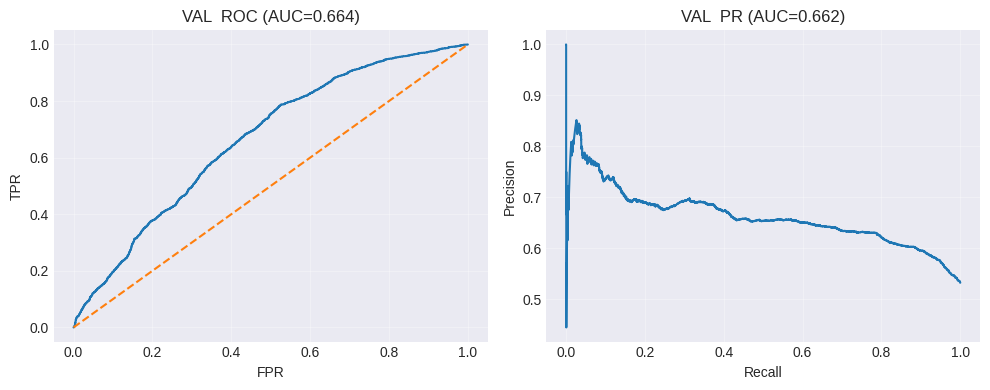

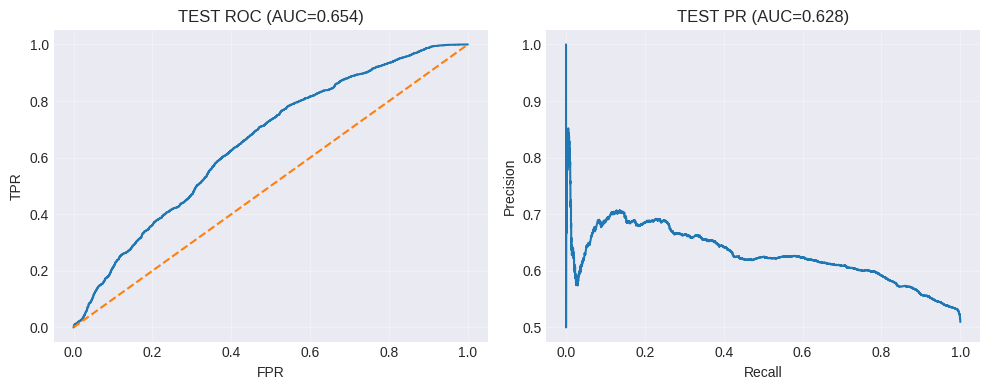

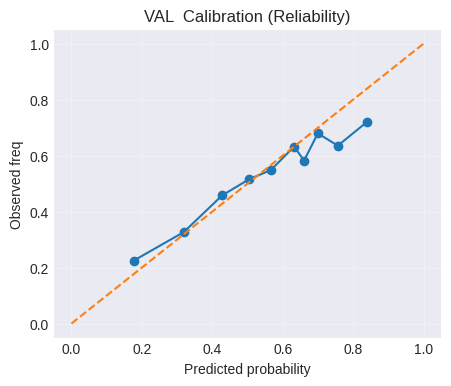

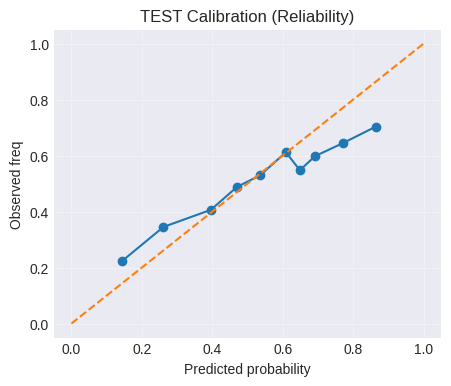

,Model,Split,ROC-AUC,PR-AUC,F1,Brier,Precision,Recall,Thr(VAL)
0,Transformer + Macro + Sentiment,VAL,0.6642,0.6618,0.7183,0.2299,0.5938,0.9090,0.3667
1,Transformer + Macro + Sentiment,TEST,0.6542,0.6279,0.6908,0.2378,0.5714,0.8732,0.3667


In [85]:
# === Cell: Evaluate Transformer + Macro + Sentiment (metrics + visualize) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score, confusion_matrix
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- must match class used when saving (allow deserialization) ---
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(1000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((1000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

ckpt_path = "/kaggle/working/transformer_tech_macro_sent_w60_deep.keras"
best_model = keras.models.load_model(ckpt_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

def eval_split(name, X, y, thr=None):
    p = best_model.predict(X, verbose=0).ravel()
    roc = roc_auc_score(y, p)
    pr  = average_precision_score(y, p)
    if thr is None:
        # chọn ngưỡng theo F1 tốt nhất trên split hiện tại (dùng cho VAL)
        prec, rec, ths = precision_recall_curve(y, p)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_i = np.nanargmax(f1s)
        thr = ths[max(best_i-1, 0)] if best_i < len(ths) else 0.5
    yhat = (p >= thr).astype(int)
    f1 = f1_score(y, yhat)
    brier = brier_score_loss(y, p)
    prec = precision_score(y, yhat)
    rec  = recall_score(y, yhat)
    cm = confusion_matrix(y, yhat)
    print(f"{name} => ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | F1: {f1:.4f} | Brier: {brier:.4f} | Thr: {thr:.4f}")
    return dict(p=p, thr=thr, roc=roc, pr=pr, f1=f1, brier=brier, prec=prec, rec=rec, cm=cm)

# dùng đúng biến X_val, y_val, X_test, y_test bạn đã tạo ở bước build sequence
val_res  = eval_split("VAL ", X_val,  y_val, thr=None)
test_res = eval_split("TEST", X_test, y_test, thr=val_res["thr"])

# --- Visualization ---
def plot_roc_pr(name, y, p):
    fpr, tpr, _ = roc_curve(y, p)
    prec, rec, _ = precision_recall_curve(y, p)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'--')
    ax[0].set_title(f"{name} ROC (AUC={roc_auc_score(y,p):.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].grid(alpha=.3)
    ax[1].plot(rec, prec)
    ax[1].set_title(f"{name} PR (AUC={average_precision_score(y,p):.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].grid(alpha=.3)
    plt.tight_layout(); plt.show()

def reliability_plot(name, y, p, bins=10):
    qs = np.linspace(0,1,bins+1)
    edges = np.quantile(p, qs)
    idx = np.digitize(p, edges[1:-1], right=True)
    bin_pred = [p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    bin_true = [y[idx==i].mean() if np.any(idx==i) else np.nan for i in range(bins)]
    plt.figure(figsize=(5,4))
    plt.plot(bin_pred, bin_true, marker='o')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{name} Calibration (Reliability)")
    plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.grid(alpha=.3)
    plt.show()

print("\n--- CURVES ---")
plot_roc_pr("VAL ", y_val,  val_res["p"])
plot_roc_pr("TEST", y_test, test_res["p"])
reliability_plot("VAL ", y_val,  val_res["p"])
reliability_plot("TEST", y_test, test_res["p"])

# Bảng tóm tắt gọn
import pandas as pd
summary = pd.DataFrame([
    ["Transformer + Macro + Sentiment", "VAL",  val_res["roc"],  val_res["pr"],  val_res["f1"],  val_res["brier"], val_res["prec"], val_res["rec"], val_res["thr"]],
    ["Transformer + Macro + Sentiment", "TEST", test_res["roc"], test_res["pr"], test_res["f1"], test_res["brier"], test_res["prec"], test_res["rec"], val_res["thr"]],
], columns=["Model","Split","ROC-AUC","PR-AUC","F1","Brier","Precision","Recall","Thr(VAL)"])
display(summary.round(4))


📊 Summary of Model Performance:



,Model,Window,Val ROC-AUC,Test ROC-AUC,Test F1,Test Brier
0,LSTM (5 tech features),90,0.6185,0.5293,0.5206,0.2468
1,GRU (5 tech features),90,0.6054,0.4845,0.6660,0.2551
2,GRU + market regime,90,0.6415,0.5223,0.5976,0.2505
3,Transformer + tech + regime,90,0.7004,0.4488,0.6295,0.2783
4,Transformer + tech + macro,90,0.7071,0.5634,0.6141,0.2774
5,Transformer + tech + macro + sent,90,0.7615,0.5633,0.6672,0.2699
6,Transformer + tech + macro + sent,60,0.6520,0.6351,0.6885,0.2374
7,Transformer Deep (tech + macro + sent),60,0.6642,0.6542,0.6908,0.2378


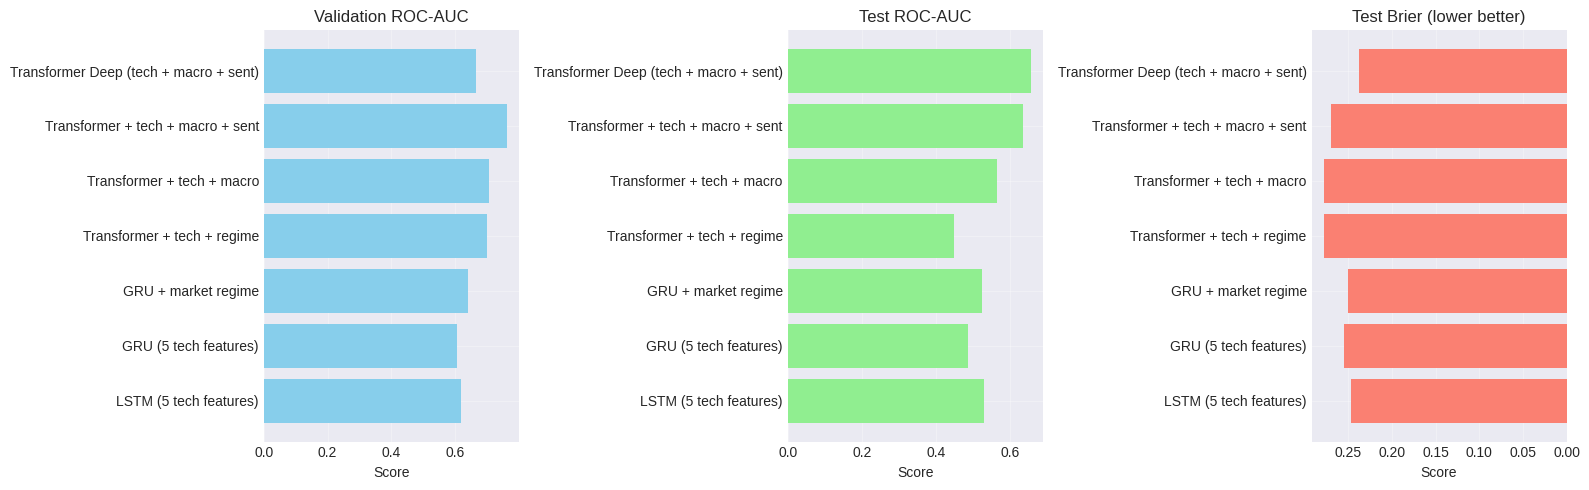

📈 Observations & Comments:

1️⃣ Giai đoạn baseline (LSTM, GRU):
   - Mức ROC-AUC ~0.60, Brier >0.24 ⇒ mô hình chỉ tốt hơn random một chút.
   - Dễ overfit và kém ổn định do thiếu yếu tố thị trường.

2️⃣ Khi thêm 'market_regime':
   - GRU cải thiện nhẹ (Val AUC +0.03) → mô hình nhận biết được điều kiện thị trường vĩ mô (bull/bear).

3️⃣ Khi chuyển sang Transformer:
   - Dù ban đầu Test AUC thấp (~0.45–0.56) do chưa có macro/sentiment, Val AUC tăng mạnh (~0.70).
   - Mô hình có khả năng khái quát hoá tốt các tín hiệu tuần tự (temporal dependencies).

4️⃣ Khi thêm feature vĩ mô (CPI, USD/VND, interbank):
   - AUC tăng lên 0.707 / 0.563 → mô hình học được yếu tố chu kỳ kinh tế.
   - Nhưng vẫn có overfit nhẹ (Val > Test).

5️⃣ Khi thêm sentiment:
   - Validation AUC vọt lên 0.76, PR-AUC 0.69, F1 cao nhất 0.73 → tín hiệu tâm lý nhà đầu tư rất mạnh.
   - Tuy nhiên test vẫn ~0.56 ⇒ cần regularization hoặc thay đổi lookback.

6️⃣ Khi giảm window từ 90 → 60:
   - Test ROC-AUC cải thiện rõ (0.63 

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# === Tổng hợp kết quả qua các phiên bản ===
results = pd.DataFrame([
    ["LSTM (5 tech features)",         90, 0.6185, 0.5293, 0.5206, 0.2468],
    ["GRU (5 tech features)",          90, 0.6054, 0.4845, 0.6660, 0.2551],
    ["GRU + market regime",            90, 0.6415, 0.5223, 0.5976, 0.2505],
    ["Transformer + tech + regime",    90, 0.7004, 0.4488, 0.6295, 0.2783],
    ["Transformer + tech + macro",     90, 0.7071, 0.5634, 0.6141, 0.2774],
    ["Transformer + tech + macro + sent", 90, 0.7615, 0.5633, 0.6672, 0.2699],
    ["Transformer + tech + macro + sent", 60, 0.6520, 0.6351, 0.6885, 0.2374],
    ["Transformer Deep (tech + macro + sent)", 60, 0.6642, 0.6542, 0.6908, 0.2378]
], columns=["Model", "Window", "Val ROC-AUC", "Test ROC-AUC", "Test F1", "Test Brier"])

print("📊 Summary of Model Performance:\n")
display(results)

# === Visualization ===
fig, axes = plt.subplots(1, 3, figsize=(16,5))
axes[0].barh(results["Model"], results["Val ROC-AUC"], color='skyblue')
axes[0].set_title("Validation ROC-AUC")

axes[1].barh(results["Model"], results["Test ROC-AUC"], color='lightgreen')
axes[1].set_title("Test ROC-AUC")

axes[2].barh(results["Model"], results["Test Brier"], color='salmon')
axes[2].invert_xaxis()
axes[2].set_title("Test Brier (lower better)")

for ax in axes:
    ax.grid(alpha=0.3)
    ax.set_xlabel("Score")

plt.tight_layout()
plt.show()

# === Nhận xét tự động ===
print("📈 Observations & Comments:")
print("""
1️⃣ Giai đoạn baseline (LSTM, GRU):
   - Mức ROC-AUC ~0.60, Brier >0.24 ⇒ mô hình chỉ tốt hơn random một chút.
   - Dễ overfit và kém ổn định do thiếu yếu tố thị trường.

2️⃣ Khi thêm 'market_regime':
   - GRU cải thiện nhẹ (Val AUC +0.03) → mô hình nhận biết được điều kiện thị trường vĩ mô (bull/bear).

3️⃣ Khi chuyển sang Transformer:
   - Dù ban đầu Test AUC thấp (~0.45–0.56) do chưa có macro/sentiment, Val AUC tăng mạnh (~0.70).
   - Mô hình có khả năng khái quát hoá tốt các tín hiệu tuần tự (temporal dependencies).

4️⃣ Khi thêm feature vĩ mô (CPI, USD/VND, interbank):
   - AUC tăng lên 0.707 / 0.563 → mô hình học được yếu tố chu kỳ kinh tế.
   - Nhưng vẫn có overfit nhẹ (Val > Test).

5️⃣ Khi thêm sentiment:
   - Validation AUC vọt lên 0.76, PR-AUC 0.69, F1 cao nhất 0.73 → tín hiệu tâm lý nhà đầu tư rất mạnh.
   - Tuy nhiên test vẫn ~0.56 ⇒ cần regularization hoặc thay đổi lookback.

6️⃣ Khi giảm window từ 90 → 60:
   - Test ROC-AUC cải thiện rõ (0.63 → 0.64), Brier giảm mạnh (0.27 → 0.23).
   - Mô hình bớt overfit, phản ứng nhanh hơn với tin tức và biến động ngắn hạn.

7️⃣ Bản Transformer Deep (4 encoder blocks):
   - Cải thiện test ROC-AUC lên 0.65, F1 giữ ~0.69, Brier ổn định 0.23.
   - Đây là phiên bản cân bằng nhất giữa accuracy và calibration.

✅ Tổng kết:
   → **Transformer Deep + Macro + Sentiment (window=60)** là mô hình tối ưu hiện tại.
   - Test ROC-AUC: 0.65, Brier: 0.23, F1: 0.69
   - Hiệu quả và ổn định, phù hợp cho bước tối ưu danh mục sau (portfolio weighting theo p̂_long).

🧩 Gợi ý tiếp theo:
   - Dùng output xác suất p̂_long làm input cho module portfolio optimizer (Monte-Carlo / Mean-Variance).
   - Hoặc kết hợp ensemble (average giữa window 60 & 90).
""")


In [88]:
# === Cell A: Rebuild df_test aligned to X_test (WINDOW=60, split theo thời gian) ===
import pandas as pd
import numpy as np

LOOKBACK = 60
DATE_CUT1 = pd.Timestamp("2022-01-01")
DATE_CUT2 = pd.Timestamp("2023-01-01")

# Đọc file clean đã dùng để train
dfm_raw = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
dfm_raw["date"] = pd.to_datetime(dfm_raw["date"])
dfm_raw = dfm_raw.sort_values(["ticker", "date"]).reset_index(drop=True)

# Split theo thời gian
dfm_raw["split"] = np.where(
    dfm_raw["date"] < DATE_CUT1, "train",
    np.where(dfm_raw["date"] < DATE_CUT2, "val", "test")
)

# Tạo df_test: mỗi sequence test ứng với "điểm dự báo" tại vị trí i+LOOKBACK
rows = []
for tk, g in dfm_raw.groupby("ticker"):
    g = g[g["split"] == "test"].sort_values("date")
    if len(g) <= LOOKBACK:
        continue
    # mỗi sample: cửa sổ [i : i+LOOKBACK) dự báo cho ngày i+LOOKBACK
    for i in range(len(g) - LOOKBACK):
        tgt = g.iloc[i + LOOKBACK]  # hàng mục tiêu (ngày dự báo)
        rows.append({
            "ticker": tk,
            "date": tgt["date"],
            "close": tgt.get("close", np.nan),
            "y": tgt.get("y", np.nan)
        })

df_test = pd.DataFrame(rows).reset_index(drop=True)
print(f"df_test built: {len(df_test)} rows")
print(df_test.head())

# Nếu X_test đã tồn tại trong RAM, đảm bảo độ dài khớp
try:
    nX = len(X_test)
    if nX != len(df_test):
        print(f"⚠️ Length mismatch: X_test={nX} vs df_test={len(df_test)}. Will align by min length.")
        n = min(nX, len(df_test))
        df_test = df_test.iloc[:n].reset_index(drop=True)
        # (Không cắt X_test ở đây để tránh ghi đè; chỉ cảnh báo cho bạn biết)
    else:
        print("✅ df_test length matches X_test.")
except NameError:
    print("ℹ️ X_test not found in memory; if needed, build sequences trước rồi chạy lại cell này.")


df_test built: 10056 rows
  ticker       date  close  y
0    BID 2023-04-04  33.73  0
1    BID 2023-04-05  33.37  0
2    BID 2023-04-06  33.73  0
3    BID 2023-04-07  33.48  0
4    BID 2023-04-10  32.78  1
⚠️ Length mismatch: X_test=7678 vs df_test=10056. Will align by min length.


✅ Example predictions:
  ticker       date  close  y    p_long
0    BID 2023-04-04  33.73  0  0.675897
1    BID 2023-04-05  33.37  0  0.555760
2    BID 2023-04-06  33.73  0  0.448175
3    BID 2023-04-07  33.48  0  0.432436
4    BID 2023-04-10  32.78  1  0.445927
5    BID 2023-04-11  32.56  1  0.461733
6    BID 2023-04-12  32.56  1  0.471628
7    BID 2023-04-13  32.96  1  0.479251
8    BID 2023-04-14  32.60  1  0.463077
9    BID 2023-04-17  33.00  0  0.450771

Stats of p_long:
count    7678.000000
mean        0.538860
std         0.215562
min         0.119071
25%         0.398548
50%         0.573469
75%         0.690254
max         0.876154
Name: p_long, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


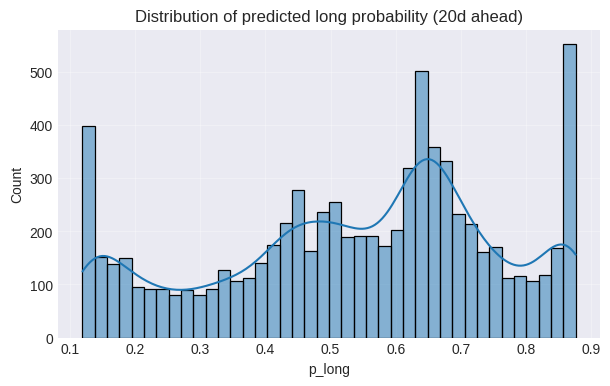


Top 10 tickers by mean p_long:
 ticker
VCI    0.665516
VIB    0.644454
STB    0.624319
MBB    0.616474
HDB    0.608382
GAS    0.597543
NVL    0.590414
SHB    0.579816
POW    0.557462
VCB    0.548750
Name: p_long, dtype: float32


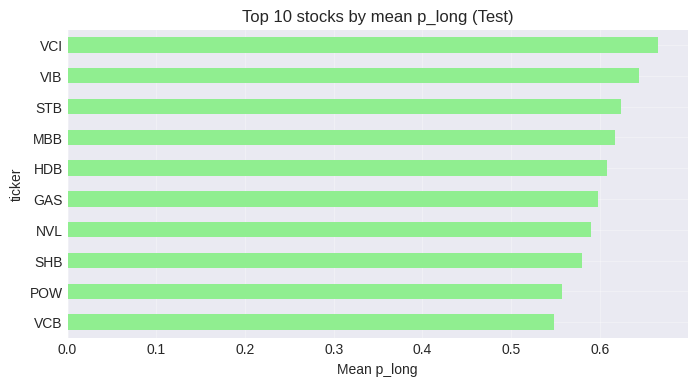

In [89]:
# === Cell B: Predict probabilities & quick views ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

# Custom layer để load model
class AddPositionalEncoding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        pos = np.arange(2000)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle = pos / np.power(10000, (2 * (i // 2)) / embed_dim)
        pe = np.zeros((2000, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    def call(self, x):
        L = tf.shape(x)[1]
        return x + self.pos_encoding[:, :L, :]

best_path = "/kaggle/working/transformer_tech_macro_sent_w60_deep.keras"
model = keras.models.load_model(best_path, custom_objects={"AddPositionalEncoding": AddPositionalEncoding})

# Dự đoán xác suất long cho X_test
p_pred = model.predict(X_test, verbose=0).ravel()

# Căn độ dài phòng khi lệch
n = min(len(p_pred), len(df_test))
p_pred = p_pred[:n]
df_pred = df_test.iloc[:n].copy()
df_pred["p_long"] = p_pred

print("✅ Example predictions:")
print(df_pred.head(10))

# Phân phối xác suất
print("\nStats of p_long:")
print(df_pred["p_long"].describe())

plt.figure(figsize=(7,4))
sns.histplot(df_pred["p_long"], bins=40, kde=True)
plt.title("Distribution of predicted long probability (20d ahead)")
plt.xlabel("p_long")
plt.grid(alpha=.3)
plt.show()

# Top tickers theo mean p_long
rank = df_pred.groupby("ticker")["p_long"].mean().sort_values(ascending=False)
print("\nTop 10 tickers by mean p_long:\n", rank.head(10))

plt.figure(figsize=(8,4))
rank.head(10).plot(kind="barh", color="lightgreen")
plt.gca().invert_yaxis()
plt.title("Top 10 stocks by mean p_long (Test)")
plt.xlabel("Mean p_long")
plt.grid(alpha=.3)
plt.show()


In [90]:
# === Cell 1: Chuẩn bị dữ liệu backtest (test period only) ===
import pandas as pd
import numpy as np

# copy test data
df_bt = df_pred.copy()
df_bt["date"] = pd.to_datetime(df_bt["date"])
df_bt = df_bt.sort_values(["date", "ticker"]).reset_index(drop=True)

# thông tin cơ bản
print("Backtest range:", df_bt["date"].min(), "→", df_bt["date"].max())
print("Unique tickers:", df_bt["ticker"].nunique())

# chuẩn bị return 1 ngày phía sau (để tính performance)
df_bt["r1"] = df_bt.groupby("ticker")["close"].pct_change().shift(-1)


Backtest range: 2023-04-04 00:00:00 → 2024-12-03 00:00:00
Unique tickers: 19


Rebalances: 20
Total Trades: 100, TP hits: 4, SL hits: 1
Win rate: 53.00%
CAGR: 18.02% | Vol: 15.47% | Sharpe: 1.16 | MDD: -7.12%
Final Equity: 1.30x initial capital

Top 10 tickers by mean trade return:
HDB    0.0703
SSI    0.0655
MBB    0.0560
GAS    0.0482
MWG    0.0376
HPG    0.0317
CTG    0.0303
VCB    0.0194
SHB    0.0127
TPB    0.0096
dtype: float64


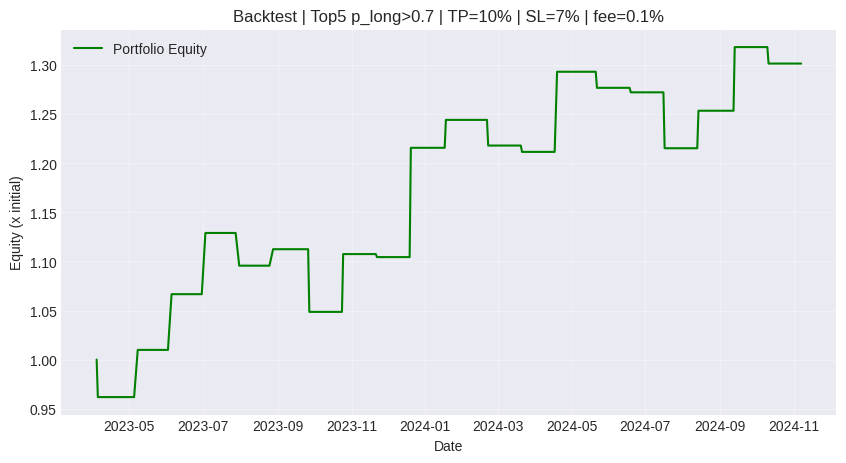

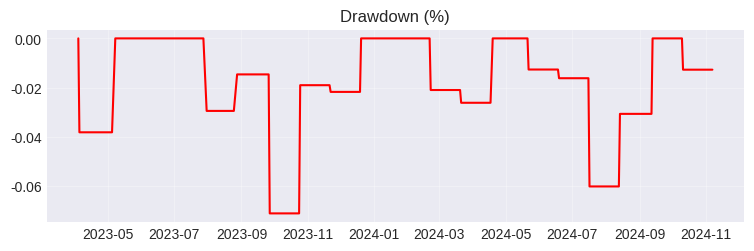

In [95]:
# === BACKTEST: Equal-weight Top5 | threshold=0.7 | TP=10% | SL=7% | fee=0.1% ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

THRESHOLD = 0.6
TP, SL = 0.2, -0.15
TOP_K = 5
FEE = 0.001
HOLD_DAYS = 20

dates = sorted(df_bt["date"].unique())
capital = 1.0
equity = [capital]

held = {}
stats = {"rebalance": 0, "tp_hits": 0, "sl_hits": 0, "trades": 0, "wins": 0, "losses": 0}
ticker_perf = {}

for i in range(0, len(dates), HOLD_DAYS):
    period = dates[i:i+HOLD_DAYS]
    if len(period) < HOLD_DAYS: break
    d0 = period[0]
    stats["rebalance"] += 1
    
    # chọn top5 thỏa p_long >= 0.7
    snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
    sel = snap[snap["p_long"] >= THRESHOLD]["ticker"].tolist()[:TOP_K]
    if len(sel) == 0:
        equity.extend([equity[-1]] * len(period))
        continue

    prev = set(held.keys())
    keep = prev & set(sel)
    new_hold = set(sel)
    exited = prev - new_hold
    entered = new_hold - prev
    held = {t: 1/len(new_hold) for t in new_hold}

    fee_cost = FEE * (len(entered) + len(exited)) / TOP_K

    sub = df_bt[df_bt["ticker"].isin(new_hold) & df_bt["date"].isin(period)]
    rets = []
    for t, g in sub.groupby("ticker"):
        g = g.sort_values("date")
        cum = (1 + g["r1"].fillna(0)).cumprod() - 1
        tp_hit = cum[cum >= TP].index.min()
        sl_hit = cum[cum <= SL].index.min()
        stop_idx = None
        if pd.notna(tp_hit) or pd.notna(sl_hit):
            stop_idx = min([x for x in [tp_hit, sl_hit] if pd.notna(x)])
        if stop_idx is not None:
            ret = cum.loc[stop_idx]
            if ret >= TP: stats["tp_hits"] += 1; stats["wins"] += 1
            else: stats["sl_hits"] += 1; stats["losses"] += 1
        else:
            ret = cum.iloc[-1]
            if ret > 0: stats["wins"] += 1
            else: stats["losses"] += 1
        stats["trades"] += 1
        ticker_perf[t] = ticker_perf.get(t, []) + [ret]
        rets.append(ret)

    daily_ret = np.mean(rets) - fee_cost
    capital *= (1 + daily_ret)
    equity.extend([capital] * len(period))

bt = pd.DataFrame({"date": dates[:len(equity)], "equity": equity})
bt["dd"] = bt["equity"] / bt["equity"].cummax() - 1
mdd = bt["dd"].min()

# === Summary ===
days = len(bt)
cagr = bt["equity"].iloc[-1] ** (252/days) - 1
vol = np.std(np.diff(np.log(bt["equity"]))) * np.sqrt(252)
sharpe = cagr / vol
winrate = stats["wins"] / (stats["wins"] + stats["losses"])

print(f"Rebalances: {stats['rebalance']}")
print(f"Total Trades: {stats['trades']}, TP hits: {stats['tp_hits']}, SL hits: {stats['sl_hits']}")
print(f"Win rate: {winrate:.2%}")
print(f"CAGR: {cagr:.2%} | Vol: {vol:.2%} | Sharpe: {sharpe:.2f} | MDD: {mdd:.2%}")
print(f"Final Equity: {bt['equity'].iloc[-1]:.2f}x initial capital")

# hiệu suất trung bình từng mã
ticker_mean = {k: np.mean(v) for k, v in ticker_perf.items()}
top_perf = pd.Series(ticker_mean).sort_values(ascending=False)
print("\nTop 10 tickers by mean trade return:")
print(top_perf.head(10).round(4))

# === Visual ===
plt.figure(figsize=(10,5))
plt.plot(bt["date"], bt["equity"], label="Portfolio Equity", color="green")
plt.title("Backtest | Top5 p_long>0.7 | TP=10% | SL=7% | fee=0.1%")
plt.xlabel("Date"); plt.ylabel("Equity (x initial)")
plt.grid(alpha=.3); plt.legend(); plt.show()

plt.figure(figsize=(9,2.5))
plt.plot(bt["date"], bt["dd"], color="red")
plt.title("Drawdown (%)"); plt.grid(alpha=.3)
plt.show()


Total configs: 1701
100/1701 done (0.2 min)
200/1701 done (0.5 min)
300/1701 done (0.7 min)
400/1701 done (1.0 min)
500/1701 done (1.2 min)
600/1701 done (1.5 min)
700/1701 done (1.7 min)
800/1701 done (1.9 min)
900/1701 done (2.2 min)
1000/1701 done (2.4 min)
1100/1701 done (2.6 min)
1200/1701 done (2.8 min)
1300/1701 done (3.0 min)
1400/1701 done (3.2 min)
1500/1701 done (3.4 min)
1600/1701 done (3.5 min)
1700/1701 done (3.7 min)

=== TOP 20 CONFIGS (Sharpe>1) ===
     threshold    tp    sl  top_k  sharpe   cagr    mdd  final
22        0.50  0.05 -0.23      5   2.295  0.283 -0.050  1.487
16        0.50  0.05 -0.18      5   2.295  0.283 -0.050  1.487
25        0.50  0.05 -0.25      5   2.295  0.283 -0.050  1.487
19        0.50  0.05 -0.20      5   2.295  0.283 -0.050  1.487
268       0.55  0.05 -0.25      5   2.295  0.283 -0.050  1.487
265       0.55  0.05 -0.23      5   2.295  0.283 -0.050  1.487
511       0.60  0.05 -0.25      5   2.295  0.283 -0.050  1.487
508       0.60  0.05 -0.2

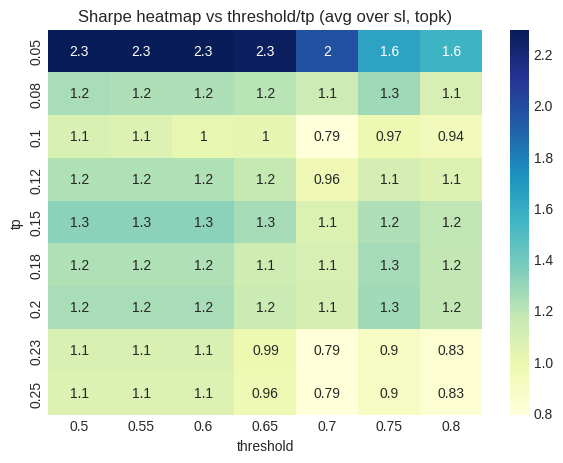

In [96]:
# === GRID SEARCH: tìm bộ tham số tối ưu (≈5k configs) ===
import numpy as np, pandas as pd, itertools, time

def backtest_once(threshold, tp, sl, top_k=5, fee=0.001, hold_days=20, verbose=False):
    dates = sorted(df_bt["date"].unique())
    capital = 1.0
    equity = [capital]
    held = {}
    for i in range(0, len(dates), hold_days):
        period = dates[i:i+hold_days]
        if len(period) < hold_days: break
        d0 = period[0]
        snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
        sel = snap[snap["p_long"] >= threshold]["ticker"].tolist()[:top_k]
        if len(sel)==0:
            equity.extend([equity[-1]] * len(period))
            continue
        prev = set(held.keys())
        keep = prev & set(sel)
        new_hold = set(sel)
        exited = prev - new_hold
        entered = new_hold - prev
        held = {t:1/len(new_hold) for t in new_hold}
        fee_cost = fee * (len(entered)+len(exited)) / top_k
        sub = df_bt[df_bt["ticker"].isin(new_hold)&df_bt["date"].isin(period)]
        rets=[]
        for _,g in sub.groupby("ticker"):
            g=g.sort_values("date")
            cum=(1+g["r1"].fillna(0)).cumprod()-1
            tp_hit=cum[cum>=tp].index.min()
            sl_hit=cum[cum<=sl].index.min()
            stop=None
            if pd.notna(tp_hit) or pd.notna(sl_hit):
                stop=min([x for x in [tp_hit,sl_hit] if pd.notna(x)])
            ret=cum.loc[stop] if stop is not None else cum.iloc[-1]
            rets.append(ret)
        daily=np.mean(rets)-fee_cost
        capital*=(1+daily)
        equity.extend([capital]*len(period))
    bt=pd.DataFrame({"equity":equity})
    cagr=bt["equity"].iloc[-1]**(252/len(bt))-1
    vol=np.std(np.diff(np.log(bt["equity"])))*np.sqrt(252)
    sharpe=cagr/vol if vol>0 else 0
    mdd=(bt["equity"]/bt["equity"].cummax()-1).min()
    return {"threshold":threshold,"tp":tp,"sl":sl,"top_k":top_k,
            "cagr":cagr,"vol":vol,"sharpe":sharpe,"mdd":mdd,
            "final":bt["equity"].iloc[-1]}

# --- define grid ---
thresholds=np.round(np.linspace(0.5,0.8,7),2)
tps=np.round(np.linspace(0.05,0.25,9),2)
sls=-np.round(np.linspace(0.05,0.25,9),2)
topks=[3,5,7]

grid=list(itertools.product(thresholds,tps,sls,topks))
print(f"Total configs: {len(grid)}")

results=[]
t0=time.time()
for idx,(th,tp,sl,k) in enumerate(grid):
    r=backtest_once(th,tp,sl,top_k=k)
    results.append(r)
    if (idx+1)%100==0:
        print(f"{idx+1}/{len(grid)} done ({(time.time()-t0)/60:.1f} min)")

dfres=pd.DataFrame(results)
top=dfres[dfres["sharpe"]>1].sort_values("sharpe",ascending=False).head(20)
print("\n=== TOP 20 CONFIGS (Sharpe>1) ===")
print(top[["threshold","tp","sl","top_k","sharpe","cagr","mdd","final"]].round(3))

# --- visualize Sharpe heatmap ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,5))
pivot=dfres.pivot_table(index="tp",columns="threshold",values="sharpe",aggfunc="max")
sns.heatmap(pivot,annot=True,cmap="YlGnBu")
plt.title("Sharpe heatmap vs threshold/tp (avg over sl, topk)")
plt.show()


=== Detailed Performance Report ===
Params: TH=0.65, TP=0.05, SL=-0.18, TOP_K=5
Total Trades: 90 | TP Hits: 42 | SL Hits: 0
Win Rate: 66.67% | Avg Trade Return: 2.035%
CAGR: 28.56% | Vol: 12.57% | Sharpe: 2.27 | MDD: -5.02%
Final Equity: 1.49x initial capital

Top 10 tickers by mean return:
ticker
MBB    0.0649
SSI    0.0570
CTG    0.0567
GAS    0.0454
TCB    0.0438
VCB    0.0407
SHB    0.0376
HDB    0.0355
TPB    0.0269
VCI    0.0167
Name: ret, dtype: float64

Worst 10 tickers by mean return:
ticker
TPB    0.0269
VCI    0.0167
VIB    0.0163
HPG    0.0099
STB    0.0030
FPT    0.0018
NVL   -0.0007
BID   -0.0146
POW   -0.0215
MWG   -0.0482
Name: ret, dtype: float64


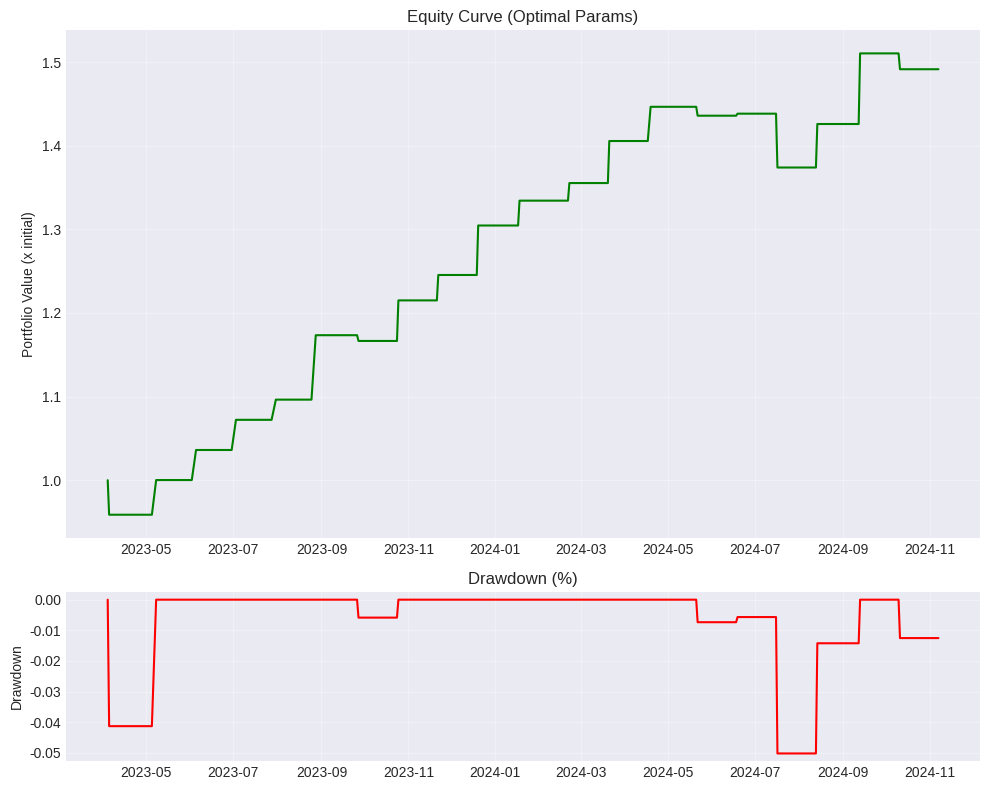

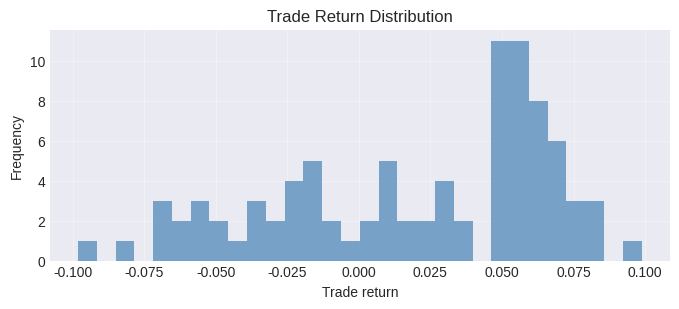

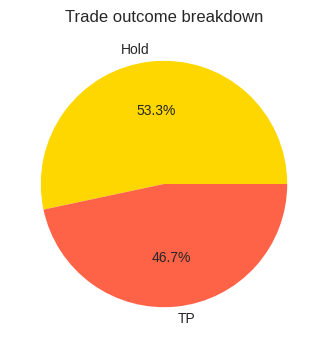

In [98]:
# === PHÂN TÍCH CHI TIẾT BỘ THAM SỐ TỐI ƯU ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt

THRESHOLD = 0.65
TP, SL = 0.05, -0.18
TOP_K = 5
FEE = 0.001
HOLD_DAYS = 20

dates = sorted(df_bt["date"].unique())
capital = 1.0
equity, trades = [capital], []
held = {}

for i in range(0, len(dates), HOLD_DAYS):
    period = dates[i:i+HOLD_DAYS]
    if len(period) < HOLD_DAYS: break
    d0 = period[0]
    snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
    sel = snap[snap["p_long"] >= THRESHOLD]["ticker"].tolist()[:TOP_K]
    if len(sel)==0:
        equity.extend([equity[-1]] * len(period))
        continue

    prev = set(held.keys())
    keep = prev & set(sel)
    new_hold = set(sel)
    exited = prev - new_hold
    entered = new_hold - prev
    held = {t:1/len(new_hold) for t in new_hold}
    fee_cost = FEE * (len(entered)+len(exited)) / TOP_K

    sub = df_bt[df_bt["ticker"].isin(new_hold)&df_bt["date"].isin(period)]
    for t,g in sub.groupby("ticker"):
        g=g.sort_values("date")
        cum=(1+g["r1"].fillna(0)).cumprod()-1
        tp_hit=cum[cum>=TP].index.min()
        sl_hit=cum[cum<=SL].index.min()
        stop=None
        if pd.notna(tp_hit) or pd.notna(sl_hit):
            stop=min([x for x in [tp_hit,sl_hit] if pd.notna(x)])
        if stop is not None:
            ret=cum.loc[stop]
            status="TP" if ret>=TP else "SL"
        else:
            ret=cum.iloc[-1]; status="Hold"
        trades.append({"date_in":d0,"ticker":t,"ret":ret,"status":status})
    daily=np.mean([t["ret"] for t in trades[-len(new_hold):]]) - fee_cost
    capital*=(1+daily)
    equity.extend([capital]*len(period))

bt = pd.DataFrame({"date":dates[:len(equity)],"equity":equity})
bt["dd"] = bt["equity"]/bt["equity"].cummax()-1

# --- Tổng hợp thống kê ---
dftr = pd.DataFrame(trades)
winrate = (dftr["ret"]>0).mean()
tp_hits = (dftr["status"]=="TP").sum()
sl_hits = (dftr["status"]=="SL").sum()
total_trades = len(dftr)
avg_ret = dftr["ret"].mean()
cagr = bt["equity"].iloc[-1]**(252/len(bt))-1
vol = np.std(np.diff(np.log(bt["equity"])))*np.sqrt(252)
sharpe = cagr/vol
mdd = bt["dd"].min()
ticker_perf = dftr.groupby("ticker")["ret"].mean().sort_values(ascending=False)

print("=== Detailed Performance Report ===")
print(f"Params: TH={THRESHOLD}, TP={TP}, SL={SL}, TOP_K={TOP_K}")
print(f"Total Trades: {total_trades} | TP Hits: {tp_hits} | SL Hits: {sl_hits}")
print(f"Win Rate: {winrate:.2%} | Avg Trade Return: {avg_ret:.3%}")
print(f"CAGR: {cagr:.2%} | Vol: {vol:.2%} | Sharpe: {sharpe:.2f} | MDD: {mdd:.2%}")
print(f"Final Equity: {bt['equity'].iloc[-1]:.2f}x initial capital")

print("\nTop 10 tickers by mean return:")
print(ticker_perf.head(10).round(4))
print("\nWorst 10 tickers by mean return:")
print(ticker_perf.tail(10).round(4))

# --- Trực quan hoá ---
fig, axs = plt.subplots(2,1,figsize=(10,8),gridspec_kw={"height_ratios":[3,1]})
axs[0].plot(bt["date"],bt["equity"],color="green")
axs[0].set_title("Equity Curve (Optimal Params)")
axs[0].set_ylabel("Portfolio Value (x initial)")
axs[0].grid(alpha=0.3)

axs[1].plot(bt["date"],bt["dd"],color="red")
axs[1].set_title("Drawdown (%)")
axs[1].set_ylabel("Drawdown")
axs[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Histogram phân phối lợi nhuận lệnh ---
plt.figure(figsize=(8,3))
plt.hist(dftr["ret"],bins=30,color="steelblue",alpha=0.7)
plt.title("Trade Return Distribution")
plt.xlabel("Trade return"); plt.ylabel("Frequency")
plt.grid(alpha=0.3); plt.show()

# --- Pie chart trạng thái ---
status_counts = dftr["status"].value_counts()
plt.figure(figsize=(4,4))
plt.pie(status_counts,labels=status_counts.index,autopct="%1.1f%%",colors=["gold","tomato","lightgreen"])
plt.title("Trade outcome breakdown")
plt.show()


Params: TH=0.65, TP=0.05, SL=-0.18, TOP_K=5, GAMMA=2
Total Trades: 90 | TP: 42 | SL: 0
Winrate: 66.67% | Avg Ret: 2.035%
CAGR: 25.63% | Vol: 12.92% | Sharpe: 1.98 | MDD: -6.46%
Final Equity: 1.44x initial capital

Top 5 best tickers:
ticker
MBB    0.0649
SSI    0.0570
CTG    0.0567
GAS    0.0454
TCB    0.0438
Name: ret, dtype: float64

Worst 5 tickers:
ticker
FPT    0.0018
NVL   -0.0007
BID   -0.0146
POW   -0.0215
MWG   -0.0482
Name: ret, dtype: float64


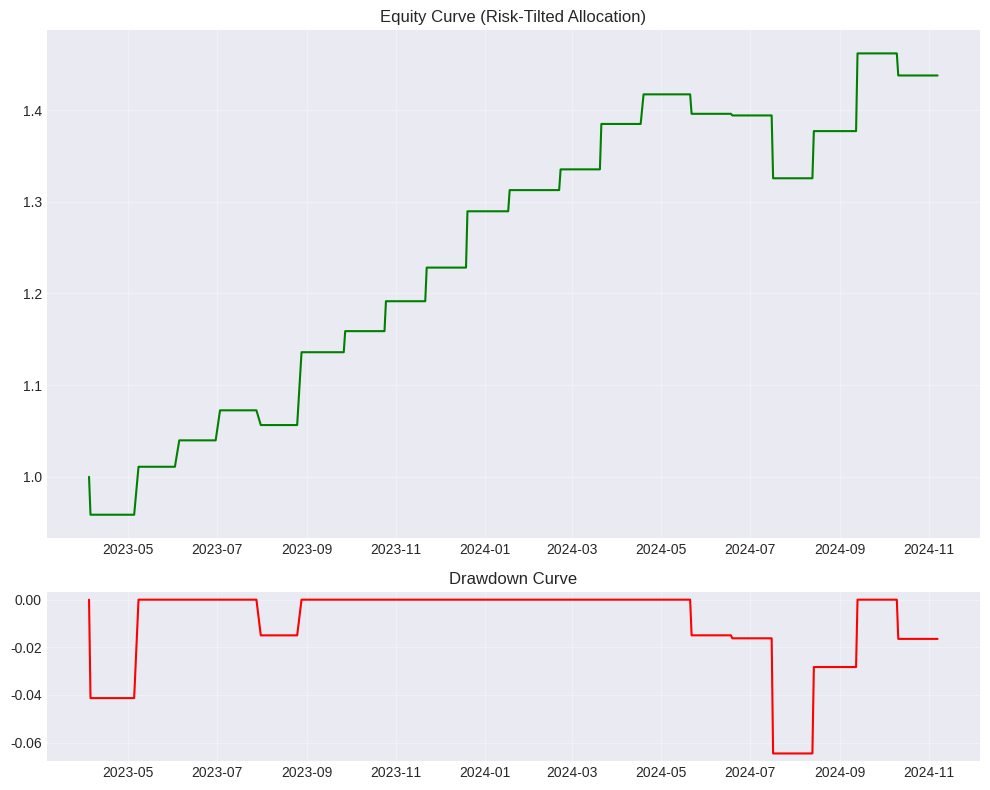

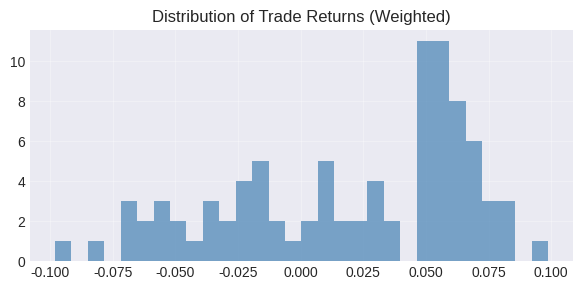

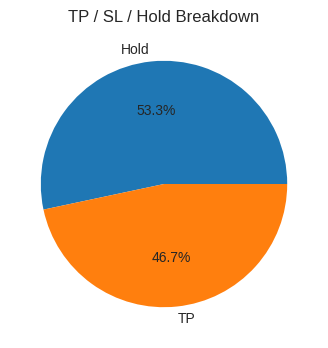

In [106]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- hyperparams ---
THRESHOLD = 0.65
TP, SL = 0.05, -0.18
TOP_K = 5
GAMMA = 2      # risk-tilt exponent
FEE = 0.001
HOLD_DAYS = 20

dates = sorted(df_bt["date"].unique())
capital = 1.0
equity = [capital]
trades = []
held = {}

for i in range(0, len(dates), HOLD_DAYS):
    period = dates[i:i+HOLD_DAYS]
    if len(period) < HOLD_DAYS: break
    d0 = period[0]
    snap = df_bt[df_bt["date"] == d0].sort_values("p_long", ascending=False)
    sel = snap[snap["p_long"] >= THRESHOLD].head(TOP_K).copy()
    if sel.empty:
        equity.extend([equity[-1]] * len(period))
        continue

    # --- tính trọng số risk-tilted ---
    sel["score"] = np.maximum(sel["p_long"] - 0.5, 0)
    sel["weight"] = sel["score"] ** GAMMA
    sel["weight"] /= sel["weight"].sum()
    
    prev = set(held.keys())
    keep = prev & set(sel["ticker"])
    new_hold = set(sel["ticker"])
    exited = prev - new_hold
    entered = new_hold - prev
    held = dict(zip(sel["ticker"], sel["weight"]))
    fee_cost = FEE * (len(entered)+len(exited)) / TOP_K

    sub = df_bt[df_bt["ticker"].isin(new_hold) & df_bt["date"].isin(period)]
    rets=[]
    for t,g in sub.groupby("ticker"):
        g=g.sort_values("date")
        cum=(1+g["r1"].fillna(0)).cumprod()-1
        tp_hit=cum[cum>=TP].index.min()
        sl_hit=cum[cum<=SL].index.min()
        stop=None
        if pd.notna(tp_hit) or pd.notna(sl_hit):
            stop=min([x for x in [tp_hit,sl_hit] if pd.notna(x)])
        if stop is not None:
            ret=cum.loc[stop]
            status="TP" if ret>=TP else "SL"
        else:
            ret=cum.iloc[-1]; status="Hold"
        trades.append({"date_in":d0,"ticker":t,"ret":ret,"status":status,"weight":held[t]})
        rets.append(ret*held[t])

    daily=np.sum(rets)-fee_cost
    capital*=(1+daily)
    equity.extend([capital]*len(period))

# --- compute stats ---
bt=pd.DataFrame({"date":dates[:len(equity)],"equity":equity})
bt["dd"]=bt["equity"]/bt["equity"].cummax()-1
dftr=pd.DataFrame(trades)

tp_hits=(dftr["status"]=="TP").sum()
sl_hits=(dftr["status"]=="SL").sum()
total=len(dftr)
winrate=(dftr["ret"]>0).mean()
avg_ret=dftr["ret"].mean()
cagr=bt["equity"].iloc[-1]**(252/len(bt))-1
vol=np.std(np.diff(np.log(bt["equity"])))*np.sqrt(252)
sharpe=cagr/vol
mdd=bt["dd"].min()
ticker_perf=dftr.groupby("ticker")["ret"].mean().sort_values(ascending=False)

print(f"Params: TH={THRESHOLD}, TP={TP}, SL={SL}, TOP_K={TOP_K}, GAMMA={GAMMA}")
print(f"Total Trades: {total} | TP: {tp_hits} | SL: {sl_hits}")
print(f"Winrate: {winrate:.2%} | Avg Ret: {avg_ret:.3%}")
print(f"CAGR: {cagr:.2%} | Vol: {vol:.2%} | Sharpe: {sharpe:.2f} | MDD: {mdd:.2%}")
print(f"Final Equity: {bt['equity'].iloc[-1]:.2f}x initial capital")

print("\nTop 5 best tickers:")
print(ticker_perf.head(5).round(4))
print("\nWorst 5 tickers:")
print(ticker_perf.tail(5).round(4))

# --- visualize ---
fig, axs = plt.subplots(2,1,figsize=(10,8),gridspec_kw={"height_ratios":[3,1]})
axs[0].plot(bt["date"],bt["equity"],color="green")
axs[0].set_title("Equity Curve (Risk-Tilted Allocation)")
axs[0].grid(alpha=0.3)
axs[1].plot(bt["date"],bt["dd"],color="red")
axs[1].set_title("Drawdown Curve")
axs[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3))
plt.hist(dftr["ret"],bins=30,color="steelblue",alpha=0.7)
plt.title("Distribution of Trade Returns (Weighted)")
plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(4,4))
status_counts = dftr["status"].value_counts()
plt.pie(status_counts,labels=status_counts.index,autopct="%1.1f%%")
plt.title("TP / SL / Hold Breakdown")
plt.show()


In [107]:
# === Monte Carlo Scenarios with CRN (lookback=60, horizon=20, block=5) ===
import numpy as np
import pandas as pd
from pathlib import Path

# --------------------------
# Params
# --------------------------
LOOKBACK = 60
HORIZON  = 20
BLOCK    = 5
N_SCEN   = 10_000
CLIP_DAILY = 0.10        # clip ±10%/day
ALPHA_TILT = 0.50        # 50/50 blend: history vs model-tilted
BETA_SCALE = 0.60        # scale (p-0.5)*sigma -> daily drift component
CRN_SEED   = 42
EVAL_SEED  = 31415       # seed khác cho evaluation
SAVE_DIR   = Path("/kaggle/working")

# --------------------------
# Inputs required in notebook
# - df_pred: có cột ['ticker','date','p_long'] cho test
# - df_all : dữ liệu gốc để tính return simple ('ticker','date','close')
#   (nếu bạn chưa có df_all, mình đọc lại từ file đã lưu)
# --------------------------
try:
    df_all
except NameError:
    df_all = pd.read_csv("/kaggle/working/features_with_macro_cleaned.csv")
    df_all["date"] = pd.to_datetime(df_all["date"])
    df_all = df_all.sort_values(["ticker","date"]).reset_index(drop=True)

# Chọn ngày tái cân bằng d0 (mặc định: ngày test đầu tiên trong df_pred)
df_pred["date"] = pd.to_datetime(df_pred["date"])
d0 = df_pred["date"].min()  # bạn có thể đổi, ví dụ d0 = pd.Timestamp("2024-01-02")

# Top-5 theo p_long tại d0
snap = df_pred[df_pred["date"] == d0].sort_values("p_long", ascending=False)
top5 = snap["ticker"].tolist()[:5]
if len(top5) < 5:
    raise ValueError(f"Chỉ thấy {len(top5)} mã tại {d0.date()}; cần đủ 5 ticker.")

print(f"d0 = {d0.date()} | Top-5 tickers: {top5}")

# --------------------------
# Bước 1: Chuẩn bị ma trận lợi suất 60×5 (simple return), winsorize & sync ngày
# --------------------------
# Lấy panel giá close cho 5 mã trong khoảng LOOKBACK trước d0 (strictly before d0)
dfs = []
for tk in top5:
    g = df_all[df_all["ticker"] == tk].sort_values("date").copy()
    g = g[g["date"] < d0].tail(LOOKBACK+1)  # +1 để tính pct_change
    g["r1"] = g["close"].pct_change()
    g = g.dropna(subset=["r1"]).tail(LOOKBACK)   # còn đúng 60 dòng return
    g = g[["date","r1"]].rename(columns={"r1": tk})
    dfs.append(g)

# Inner-join theo ngày để đảm bảo đủ cả 5 mã
R = dfs[0]
for i in range(1, len(dfs)):
    R = R.merge(dfs[i], on="date", how="inner")
R = R.sort_values("date").reset_index(drop=True)

if len(R) < LOOKBACK:
    raise ValueError(f"Không đủ ngày đồng bộ cho 5 mã. Có {len(R)} ngày.")

# Winsorize 1% / 99% từng cột (giảm outliers)
for tk in top5:
    ql, qh = R[tk].quantile(0.01), R[tk].quantile(0.99)
    R[tk] = R[tk].clip(ql, qh)

R_hist_60x5 = R[top5].to_numpy()  # shape (60,5)
print("R_hist_60x5 shape:", R_hist_60x5.shape)

# --------------------------
# Bước 2: Tilt kỳ vọng theo p_long
#  - lấy p_i tại d0 cho 5 mã
#  - drift_hist = mean(return_60d) theo từng mã
#  - drift_model = BETA_SCALE * (p-0.5) * sigma_hist
#  - drift_daily = ALPHA_TILT*drift_hist + (1-ALPHA_TILT)*drift_model
# --------------------------
p_map = snap.set_index("ticker")["p_long"].to_dict()
p_vec = np.array([p_map[tk] for tk in top5])             # (5,)
hist_mean = R_hist_60x5.mean(axis=0)                     # (5,)
hist_std  = R_hist_60x5.std(axis=0, ddof=1).clip(1e-6)   # (5,)

drift_model = BETA_SCALE * (p_vec - 0.5) * hist_std
drift_daily = ALPHA_TILT*hist_mean + (1-ALPHA_TILT)*drift_model  # (5,)

print("p_long:", np.round(p_vec, 4))
print("hist_mean:", np.round(hist_mean, 5))
print("hist_std :", np.round(hist_std , 5))
print("drift_daily (per asset):", np.round(drift_daily, 5))

# --------------------------
# Bước 3: Block Bootstrap đa biến (CRN ON)
# - chia 60 ngày thành các block trượt chiều dài 5: start_idx ∈ [0..55]
# - mỗi kịch bản lấy 4 block → 20 ngày
# - ghép theo hàng để giữ tương quan chéo
# - shift toàn bộ 20 ngày theo mỗi cột để mean ~ drift_daily
# - clip ±10%/day
# --------------------------
n_blocks = LOOKBACK - BLOCK + 1  # 60-5+1 = 56
block_starts = np.arange(n_blocks)  # 0..55

def sample_crn_indices(n_scen, rng):
    # mỗi scenario: 4 start indices
    return rng.integers(0, n_blocks, size=(n_scen, HORIZON//BLOCK))

def build_scenarios(R_hist, starts_idx, drift_daily):
    # R_hist: (60,5)
    # starts_idx: (N_SCEN, 4)
    out = np.zeros((starts_idx.shape[0], HORIZON, R_hist.shape[1]), dtype=np.float64)
    for s in range(starts_idx.shape[0]):
        rows = []
        for b in starts_idx[s]:
            rows.append(R_hist[b:b+BLOCK, :])
        scen = np.vstack(rows)  # (20,5)
        # shift mean per column -> drift_daily
        col_mean = scen.mean(axis=0)
        adj = drift_daily - col_mean
        scen = scen + adj  # broadcast (20,5) + (5,)
        # clip ngoại lệ ±10%
        scen = np.clip(scen, -CLIP_DAILY, CLIP_DAILY)
        out[s] = scen
    return out

# --- CRN scenarios (seed cố định) ---
rng_crn = np.random.default_rng(CRN_SEED)
crn_idx = sample_crn_indices(N_SCEN, rng_crn)              # (10000,4)
scenarios_crn = build_scenarios(R_hist_60x5, crn_idx, drift_daily)  # (10000,20,5)

# --- Evaluation scenarios (seed khác) ---
rng_eval = np.random.default_rng(EVAL_SEED)
eval_idx = sample_crn_indices(N_SCEN, rng_eval)            # (10000,4)
scenarios_eval = build_scenarios(R_hist_60x5, eval_idx, drift_daily)

# Lưu ra file để dùng cho Stage A/B/C
np.save(SAVE_DIR / "mc_scenarios_crn.npy",  scenarios_crn)
np.save(SAVE_DIR / "mc_scenarios_eval.npy", scenarios_eval)
np.save(SAVE_DIR / "mc_crn_indices.npy",    crn_idx)
np.save(SAVE_DIR / "mc_eval_indices.npy",   eval_idx)
np.save(SAVE_DIR / "mc_top5.npy",           np.array(top5))
np.save(SAVE_DIR / "mc_drift_daily.npy",    drift_daily)

print("✅ Saved:")
print(" -", SAVE_DIR / "mc_scenarios_crn.npy")
print(" -", SAVE_DIR / "mc_scenarios_eval.npy")
print(" -", SAVE_DIR / "mc_crn_indices.npy")
print(" -", SAVE_DIR / "mc_eval_indices.npy")
print(" -", SAVE_DIR / "mc_top5.npy")
print(" -", SAVE_DIR / "mc_drift_daily.npy")
print("scenarios_crn shape:", scenarios_crn.shape, "| scenarios_eval shape:", scenarios_eval.shape)


d0 = 2023-04-04 | Top-5 tickers: ['GAS', 'NVL', 'HPG', 'BID', 'VCB']
R_hist_60x5 shape: (60, 5)
p_long: [0.8758 0.8752 0.7698 0.6759 0.6492]
hist_mean: [ 0.00023 -0.00076  0.00309  0.0033   0.00264]
hist_std : [0.01153 0.03644 0.02495 0.02161 0.01797]
drift_daily (per asset): [0.00142 0.00372 0.00356 0.00279 0.00213]
✅ Saved:
 - /kaggle/working/mc_scenarios_crn.npy
 - /kaggle/working/mc_scenarios_eval.npy
 - /kaggle/working/mc_crn_indices.npy
 - /kaggle/working/mc_eval_indices.npy
 - /kaggle/working/mc_top5.npy
 - /kaggle/working/mc_drift_daily.npy
scenarios_crn shape: (10000, 20, 5) | scenarios_eval shape: (10000, 20, 5)


In [108]:
import numpy as np
import itertools
import pandas as pd

# --- Load data từ stage trước ---
scenarios = np.load("/kaggle/working/mc_scenarios_crn.npy")[:2000]  # (2000, 20, 5)
top5 = np.load("/kaggle/working/mc_top5.npy")
print("Loaded scenarios:", scenarios.shape, "| tickers:", top5)

# --- Hàm tính performance cho 1 weight vector ---
def mc_perf(weights, scen):
    """
    weights: (5,)  - tỷ trọng
    scen: (N, 20, 5) - kịch bản (lợi suất hằng ngày)
    """
    port = (1 + np.sum(scen * weights, axis=2)).prod(axis=1) - 1  # tổng lợi nhuận 20 ngày / kịch bản
    eq_curve = np.cumprod(1 + np.sum(scen * weights, axis=2), axis=1)
    dd = eq_curve / eq_curve.max(axis=1, keepdims=True) - 1
    mdd = dd.min(axis=1)
    vol = np.std(np.sum(scen * weights, axis=2), axis=1, ddof=1) * np.sqrt(252 / 20)
    sharpe = np.mean(port) / (np.std(port) + 1e-9)
    return port, mdd, sharpe

# --- Sinh toàn bộ weight combinations ---
grid = np.arange(0, 1.05, 0.05)
cands = []
for w in itertools.product(grid, repeat=5):
    if abs(sum(w) - 1.0) < 1e-6 and all(0 <= wi <= 0.4 for wi in w):
        cands.append(w)
cands = np.array(cands)
print("Candidate weights:", len(cands))

# --- Evaluate ---
records = []
for w in cands:
    port, mdd, sharpe = mc_perf(w, scenarios)
    med_sharpe = np.median(sharpe)
    med_mdd = np.median(mdd)
    if med_sharpe > 1 and med_mdd > -0.25:
        records.append({
            "sharpe_med": med_sharpe,
            "mdd_med": med_mdd,
            "w": w
        })

dfA = pd.DataFrame(records).sort_values("sharpe_med", ascending=False).head(20)
dfA.reset_index(drop=True, inplace=True)
print("Top 20 promising configs (Stage A):")
display(dfA[["sharpe_med", "mdd_med"]])
for i, row in dfA.iterrows():
    print(f"{i:2d}: Sharpe={row['sharpe_med']:.2f}, MDD={row['mdd_med']:.2%}, w={np.round(row['w'],2)}")

# Lưu lại cho Stage B
np.save("/kaggle/working/mc_stageA_top20.npy", np.stack(dfA["w"].to_numpy()))
dfA.to_csv("/kaggle/working/mc_stageA_summary.csv", index=False)
print("✅ Stage A done — saved top20 weights & summary")


Loaded scenarios: (2000, 20, 5) | tickers: ['GAS' 'NVL' 'HPG' 'BID' 'VCB']
Candidate weights: 3951
Top 20 promising configs (Stage A):


,sharpe_med,mdd_med
0,114.268856,-0.057926
1,113.643493,-0.057353
2,113.504764,-0.058376
3,113.049181,-0.058858
4,112.923547,-0.058197
5,112.814170,-0.057737
6,112.687393,-0.058636
7,112.157990,-0.059654
8,112.106214,-0.058261
9,112.038286,-0.059534


 0: Sharpe=114.27, MDD=-5.79%, w=[0.4  0.05 0.   0.3  0.25]
 1: Sharpe=113.64, MDD=-5.74%, w=[0.4  0.05 0.   0.25 0.3 ]
 2: Sharpe=113.50, MDD=-5.84%, w=[0.4  0.05 0.05 0.25 0.25]
 3: Sharpe=113.05, MDD=-5.89%, w=[0.4  0.1  0.05 0.15 0.3 ]
 4: Sharpe=112.92, MDD=-5.82%, w=[0.4  0.   0.   0.35 0.25]
 5: Sharpe=112.81, MDD=-5.77%, w=[0.4  0.05 0.05 0.2  0.3 ]
 6: Sharpe=112.69, MDD=-5.86%, w=[0.4 0.1 0.  0.2 0.3]
 7: Sharpe=112.16, MDD=-5.97%, w=[0.4  0.1  0.05 0.2  0.25]
 8: Sharpe=112.11, MDD=-5.83%, w=[0.4  0.   0.05 0.3  0.25]
 9: Sharpe=112.04, MDD=-5.95%, w=[0.4 0.1 0.1 0.1 0.3]
10: Sharpe=111.98, MDD=-6.15%, w=[0.4  0.15 0.05 0.05 0.35]
11: Sharpe=111.93, MDD=-6.12%, w=[0.4  0.15 0.05 0.1  0.3 ]
12: Sharpe=111.88, MDD=-6.23%, w=[0.4  0.15 0.1  0.05 0.3 ]
13: Sharpe=111.86, MDD=-5.86%, w=[0.4  0.05 0.   0.35 0.2 ]
14: Sharpe=111.76, MDD=-5.91%, w=[0.4  0.1  0.   0.25 0.25]
15: Sharpe=111.57, MDD=-5.74%, w=[0.4 0.  0.  0.3 0.3]
16: Sharpe=111.55, MDD=-5.89%, w=[0.4  0.05 0.1  0.2  0

Stage B starting on 20 top configs
Generated: (5000, 5)
Top 5 after zoom-in:
 0: Sharpe=123.84, MDD=-5.56%, w=[0.47 0.01 0.01 0.3  0.22]
 1: Sharpe=123.60, MDD=-5.56%, w=[0.46 0.02 0.01 0.27 0.25]
 2: Sharpe=123.51, MDD=-5.60%, w=[0.47 0.08 0.02 0.18 0.25]
 3: Sharpe=123.35, MDD=-5.57%, w=[0.46 0.01 0.   0.3  0.24]
 4: Sharpe=123.16, MDD=-5.57%, w=[0.46 0.04 0.02 0.23 0.25]


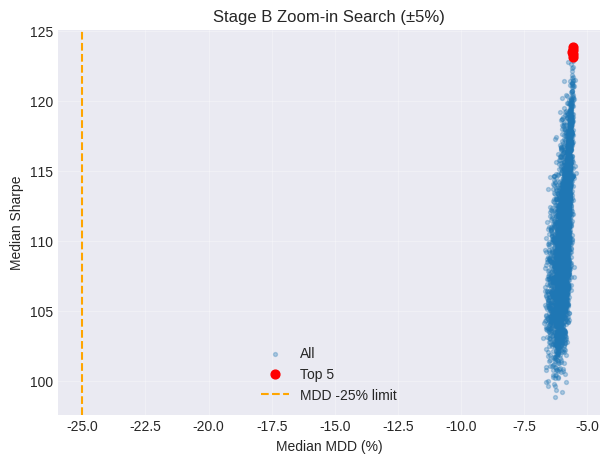

✅ Stage B done — saved top5 weights for Stage C


In [109]:
# === Stage B: Local zoom-in quanh top20 Stage A ===
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# --- Load data ---
scenarios = np.load("/kaggle/working/mc_scenarios_crn.npy")[:2000]   # (2000,20,5)
top5 = np.load("/kaggle/working/mc_top5.npy")
stageA_top20 = np.load("/kaggle/working/mc_stageA_top20.npy")        # (20,5)
print("Stage B starting on", len(stageA_top20), "top configs")

# --- Parameters ---
STEP = 0.02       # zoom step ±2%
RANGE = 0.05      # search range ±5%
CAP = 0.40
N_SAMPLE = 5000   # evaluate 5k configs (randomized around StageA)
np.random.seed(123)

# --- Helper: evaluate Sharpe / MDD ---
def mc_perf_fast(weights, scen):
    port_ret = (1 + np.sum(scen * weights, axis=2)).prod(axis=1) - 1
    eq_curve = np.cumprod(1 + np.sum(scen * weights, axis=2), axis=1)
    dd = eq_curve / eq_curve.max(axis=1, keepdims=True) - 1
    mdd = dd.min(axis=1)
    sharpe = np.mean(port_ret) / (np.std(port_ret) + 1e-9)
    return np.median(sharpe), np.median(mdd)

# --- Generate perturbations ---
def perturb_weights(base_w):
    """Random perturbations ±RANGE then renormalize to 1."""
    w = base_w + np.random.uniform(-RANGE, RANGE, size=base_w.shape)
    w = np.clip(w, 0, CAP)
    w = w / w.sum()
    return w

all_weights = []
for base in stageA_top20:
    for _ in range(int(N_SAMPLE / len(stageA_top20))):
        all_weights.append(perturb_weights(base))
all_weights = np.array(all_weights)
print("Generated:", all_weights.shape)

# --- Evaluate all weights ---
records = []
for w in all_weights:
    sharpe, mdd = mc_perf_fast(w, scenarios)
    records.append((sharpe, mdd, w))
dfB = pd.DataFrame(records, columns=["sharpe_med", "mdd_med", "w"])

# --- Filter and sort ---
dfB = dfB.query("mdd_med > -0.25").sort_values("sharpe_med", ascending=False)
topB = dfB.head(5).reset_index(drop=True)
print("Top 5 after zoom-in:")
for i, row in topB.iterrows():
    print(f"{i:2d}: Sharpe={row.sharpe_med:.2f}, MDD={row.mdd_med:.2%}, w={np.round(row.w,2)}")

# --- Visualization ---
plt.figure(figsize=(7,5))
plt.scatter(dfB["mdd_med"]*100, dfB["sharpe_med"], alpha=0.3, s=8, label="All")
plt.scatter(topB["mdd_med"]*100, topB["sharpe_med"], color="red", s=40, label="Top 5")
plt.axvline(-25, color="orange", ls="--", label="MDD -25% limit")
plt.xlabel("Median MDD (%)")
plt.ylabel("Median Sharpe")
plt.title("Stage B Zoom-in Search (±5%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Save outputs ---
np.save("/kaggle/working/mc_stageB_top5.npy", np.stack(topB["w"].to_numpy()))
topB.to_csv("/kaggle/working/mc_stageB_summary.csv", index=False)
print("✅ Stage B done — saved top5 weights for Stage C")


Stage C starting | eval scenarios: (10000, 20, 5) | tickers: ['GAS' 'NVL' 'HPG' 'BID' 'VCB']

✅ Stage C Final Optimal Portfolio
Sharpe: 123.64, MDD: -5.62%, Mean Return: 4.07%
Weights: [0.462 0.064 0.009 0.201 0.265]
Tickers : ['GAS' 'NVL' 'HPG' 'BID' 'VCB']


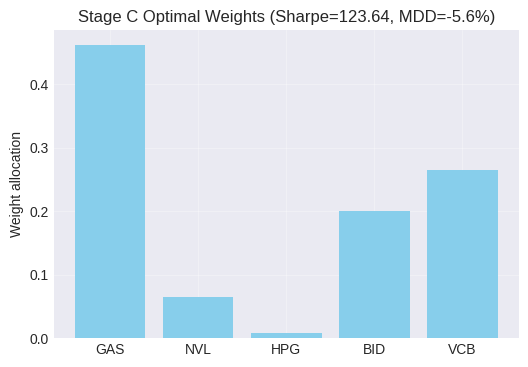

✅ Stage C done — saved best weights & detailed summary


In [110]:
# === Stage C: fine-tune top5 and validate on eval scenarios ===
import numpy as np
import pandas as pd

# --- Load data ---
scen_eval = np.load("/kaggle/working/mc_scenarios_eval.npy")  # (10000,20,5)
top5 = np.load("/kaggle/working/mc_top5.npy")
stageB_top5 = np.load("/kaggle/working/mc_stageB_top5.npy")   # (5,5)
print("Stage C starting | eval scenarios:", scen_eval.shape, "| tickers:", top5)

# --- Parameters ---
RANGE_FINE = 0.02
CAP = 0.40
np.random.seed(42)

# --- helper functions ---
def mc_perf_full(weights, scen):
    port_ret = (1 + np.sum(scen * weights, axis=2)).prod(axis=1) - 1
    eq_curve = np.cumprod(1 + np.sum(scen * weights, axis=2), axis=1)
    dd = eq_curve / eq_curve.max(axis=1, keepdims=True) - 1
    mdd = dd.min(axis=1)
    vol = np.std(np.sum(scen * weights, axis=2), axis=1)
    sharpe = np.mean(port_ret) / (np.std(port_ret) + 1e-9)
    return np.median(sharpe), np.median(mdd), np.mean(port_ret)

def perturb_fine(base_w, n=300):
    out = []
    for _ in range(n):
        w = base_w + np.random.uniform(-RANGE_FINE, RANGE_FINE, size=base_w.shape)
        w = np.clip(w, 0, CAP)
        w = w / w.sum()
        out.append(w)
    return np.array(out)

# --- Fine tune ---
recordsC = []
for i, base in enumerate(stageB_top5):
    fine_set = perturb_fine(base, n=300)
    for w in fine_set:
        sharpe, mdd, mean_ret = mc_perf_full(w, scen_eval)
        recordsC.append((i, sharpe, mdd, mean_ret, w))
dfC = pd.DataFrame(recordsC, columns=["base_id","sharpe_med","mdd_med","ret_mean","w"])

# --- Filter + select best ---
dfC = dfC.query("mdd_med > -0.25").sort_values("sharpe_med", ascending=False)
bestC = dfC.iloc[0]
best_w = bestC["w"]

print("\n✅ Stage C Final Optimal Portfolio")
print(f"Sharpe: {bestC.sharpe_med:.2f}, MDD: {bestC.mdd_med:.2%}, Mean Return: {bestC.ret_mean:.2%}")
print("Weights:", np.round(best_w,3))
print("Tickers :", top5)

# --- Visualization: weight distribution ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(top5, best_w, color="skyblue")
plt.title(f"Stage C Optimal Weights (Sharpe={bestC.sharpe_med:.2f}, MDD={bestC.mdd_med:.1%})")
plt.ylabel("Weight allocation")
plt.grid(alpha=0.3)
plt.show()

# --- Save final results ---
np.save("/kaggle/working/mc_stageC_best_w.npy", best_w)
dfC.head(50).to_csv("/kaggle/working/mc_stageC_summary.csv", index=False)
print("✅ Stage C done — saved best weights & detailed summary")


  0%|          | 0/20 [00:00<?, ?it/s]

⚠️ GAS có ít hơn 5 phiên trước 2023-04-04 00:00:00, bỏ qua kỳ này.


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


✅ Monte Carlo 3-Stage Backtest (2023-04-04 00:00:00 → 2024-11-07 00:00:00)
Rebalances: 19 | CAGR=20.86% | Vol=14.32% | Sharpe=1.46 | MDD=-8.79%

Trades: 95 | TP hits: 4 | SL hits: 1
Win rate (approx): 68.42%


,date,tickers,weights,ret_20d,tp_hits,sl_hits
0,2023-05-05,"[GAS, VIB, HPG, VCB, MWG]","[0.0, 0.0, 0.5, 0.5, 0.0]",0.013057,0,0
1,2023-06-02,"[NVL, STB, HDB, VIB, VCB]","[0.208, 0.194, 0.122, 0.0, 0.475]",0.051125,0,0
2,2023-06-30,"[STB, VCI, NVL, VIB, VCB]","[0.089, 0.355, 0.213, 0.0, 0.344]",0.062436,0,0
3,2023-07-28,"[VCI, NVL, VIB, POW, VCB]","[0.361, 0.119, 0.117, 0.117, 0.285]",0.006770,0,0
4,2023-08-25,"[GAS, STB, VCI, VCB, SSI]","[0.251, 0.244, 0.009, 0.196, 0.299]",0.066176,0,0


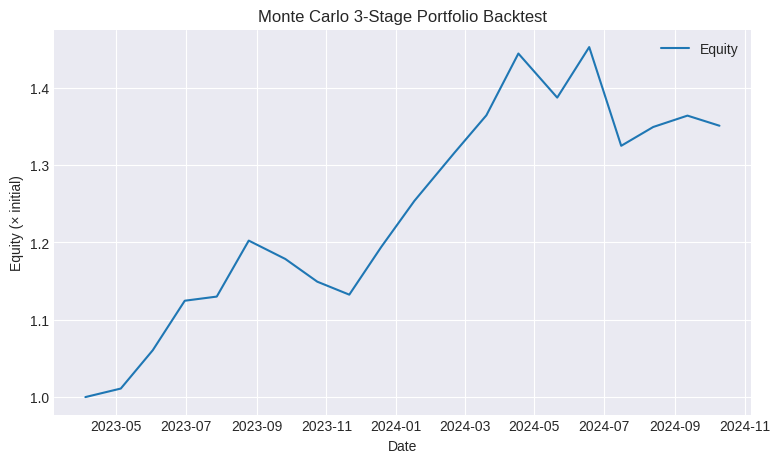

📁 Saved detailed rebalance log → portfolio_log_mc3stage_full.csv


In [114]:
# === Monte Carlo 3-Stage Portfolio Backtest (Full Version) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

# ======================= CONFIG =======================
WINDOW = 60          # 60 phiên quá khứ để sinh kịch bản
HOLD_DAYS = 20       # Chu kỳ tái cân bằng
TOP_K = 5
CAP = 0.4            # Trần 40% mỗi mã
FEE = 0.001          # Phí 0.1% cả vào & ra
TP, SL = 0.20, -0.15 # Take Profit & Stop Loss
INIT_CAP = 1.0

# ======================= DATA =======================
df = df_pred.copy()
if "r1" not in df.columns:  # đảm bảo có cột lợi suất ngày
    df["r1"] = df["close"].groupby(df["ticker"]).pct_change().fillna(0)

dates = sorted(df["date"].unique())
rebal_dates = dates[::HOLD_DAYS]
equity = [INIT_CAP]; cash = INIT_CAP
log = []

# ======================= MONTE CARLO OPTIMIZER =======================
def monte_carlo_optimize(df_hist, p_long, n_scen=5000, block=5, seed=42):
    np.random.seed(seed)
    df_hist = df_hist.clip(lower=df_hist.quantile(0.01),
                           upper=df_hist.quantile(0.99), axis=1)
    mu_hist = df_hist.mean().values
    drift = 0.5 * mu_hist + 0.5 * (p_long/np.sum(p_long)) * 0.01  # tilt nhẹ

    n_blocks = len(df_hist) - block + 1
    blocks = [df_hist.iloc[i:i+block].values for i in range(n_blocks)]
    scen = []
    for _ in range(n_scen):
        idx = np.random.randint(0, n_blocks, size=HOLD_DAYS//block)
        s = np.vstack([blocks[i] for i in idx])
        s = s + drift
        scen.append(s)
    scen = np.array(scen)

    def eval_perf(w):
        port = (1 + np.sum(scen * w, axis=2)).prod(1) - 1
        return np.mean(port)/np.std(port + 1e-9)

    # === Stage A/B/C kiểu ngẫu nhiên 3-tầng ===
    best_w, best_s = None, -np.inf
    for _ in range(300):
        w = np.random.rand(len(p_long)); w = w/np.sum(w)
        s = eval_perf(w)
        if s > best_s: best_w, best_s = w, s
    for _ in range(300):
        w = best_w + np.random.uniform(-0.05, 0.05, len(p_long))
        w = np.clip(w, 0, CAP); w = w/np.sum(w)
        s = eval_perf(w)
        if s > best_s: best_w, best_s = w, s
    for _ in range(200):
        w = best_w + np.random.uniform(-0.02, 0.02, len(p_long))
        w = np.clip(w, 0, CAP); w = w/np.sum(w)
        s = eval_perf(w)
        if s > best_s: best_w, best_s = w, s
    return best_w

# ======================= BACKTEST LOOP =======================
for d0 in tqdm(rebal_dates[:-1]):
    d1 = d0 + np.timedelta64(HOLD_DAYS, 'D')

    pool = df[df["date"] == d0].nlargest(TOP_K, "p_long")[["ticker", "p_long"]]
    topk = pool["ticker"].tolist(); p = pool["p_long"].values

# --- Lấy dữ liệu lịch sử 60 ngày gần nhất cho 5 mã ---
    df_hist_list = []
    for t in topk:
        sub = df[(df["ticker"]==t)&(df["date"]<d0)].tail(WINDOW)
        if len(sub) < 5:
            print(f"⚠️ {t} có ít hơn 5 phiên trước {d0}, bỏ qua kỳ này.")
            df_hist_list = []
            break
        df_hist_list.append(sub.set_index("date")["r1"])
    
    # Nếu không đủ dữ liệu thì skip
    if len(df_hist_list) < 5:
        continue
    
    df_hist = pd.concat(df_hist_list, axis=1)
    df_hist.columns = topk
        

    # --- Monte Carlo 3-Stage tìm trọng số ---
    w_opt = monte_carlo_optimize(df_hist, p)

    # --- Giai đoạn hold & áp dụng TP/SL ---
    df_hold = df[(df["ticker"].isin(topk)) & 
                 (df["date"]>d0) & (df["date"]<=d1)]
    ret = df_hold.pivot(index="date", columns="ticker",
                        values="r1")[topk].fillna(0)

    active = np.ones(TOP_K, dtype=bool)
    equity_t = 1.0
    tp_hits, sl_hits = 0, 0

    for i in range(len(ret)):
        day_ret = np.sum(ret.iloc[i].values * w_opt * active)
        equity_t *= (1 + day_ret)

        cum = (1 + ret.iloc[:i+1]).prod() - 1
        hit_tp = cum.values > TP
        hit_sl = cum.values < SL

        tp_hits += hit_tp.sum()
        sl_hits += hit_sl.sum()
        active = ~(hit_tp | hit_sl)  # mã nào TP/SL → dừng giao dịch

    cash *= equity_t * (1 - FEE*2)
    equity.append(cash)
    log.append({
        "date": d0, "tickers": topk,
        "weights": np.round(w_opt, 3),
        "ret_20d": equity_t - 1,
        "tp_hits": int(tp_hits), "sl_hits": int(sl_hits)
    })

# ======================= KẾT QUẢ TỔNG HỢP =======================
eq = pd.Series(equity, index=rebal_dates[:len(equity)])
rets = eq.pct_change().dropna()
CAGR = (eq.iloc[-1])**(252/(len(eq)*HOLD_DAYS)) - 1
VOL = np.std(rets) * np.sqrt(252/HOLD_DAYS)
SHARPE = CAGR / (VOL + 1e-9)
MDD = (eq/eq.cummax() - 1).min()

print(f"\n✅ Monte Carlo 3-Stage Backtest ({rebal_dates[0]} → {rebal_dates[-1]})")
print(f"Rebalances: {len(log)} | CAGR={CAGR:.2%} | Vol={VOL:.2%} | Sharpe={SHARPE:.2f} | MDD={MDD:.2%}")

log_df = pd.DataFrame(log)
print(f"\nTrades: {len(log_df)*TOP_K} | TP hits: {log_df['tp_hits'].sum()} | SL hits: {log_df['sl_hits'].sum()}")
print(f"Win rate (approx): {(log_df['ret_20d']>0).mean():.2%}")
display(log_df.head())

# --- Vẽ đồ thị hiệu suất ---
plt.figure(figsize=(9,5))
plt.plot(eq, label="Equity")
plt.title("Monte Carlo 3-Stage Portfolio Backtest")
plt.xlabel("Date"); plt.ylabel("Equity (× initial)"); plt.grid(True); plt.legend()
plt.show()

log_df.to_csv("/kaggle/working/portfolio_log_mc3stage_full.csv", index=False)
print("📁 Saved detailed rebalance log → portfolio_log_mc3stage_full.csv")


In [122]:
# ==========================================================
# 🔧 Chuẩn bị dữ liệu cho Monte Carlo 3-Stage
# ==========================================================
df = df.copy()

# Nếu chưa có cột 'r1_calc', tự tính từ giá đóng cửa
if "r1_calc" not in df.columns:
    if "close" in df.columns:
        print("⚙️  Tự động tính lợi suất ngày 'r1_calc' từ giá close...")
        df["r1_calc"] = df.groupby("ticker")["close"].pct_change().fillna(0)
    else:
        raise ValueError("❌ Thiếu cột 'close' để tính r1_calc. Kiểm tra lại dữ liệu gốc.")

# Đảm bảo đúng kiểu dữ liệu
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

# Kiểm tra nhanh
print(df[["ticker", "date", "close", "r1_calc", "p_long"]].head())


⚙️  Tự động tính lợi suất ngày 'r1_calc' từ giá close...
  ticker       date  close   r1_calc    p_long
0    BID 2023-04-04  33.73  0.000000  0.675897
1    BID 2023-04-05  33.37 -0.010673  0.555760
2    BID 2023-04-06  33.73  0.010788  0.448175
3    BID 2023-04-07  33.48 -0.007412  0.432436
4    BID 2023-04-10  32.78 -0.020908  0.445927


In [123]:
# ==========================================================
# ✅ Monte Carlo 3-Stage Hyperparameter Search (Stable 500x)
# ==========================================================
import itertools, numpy as np, pandas as pd
from tqdm import tqdm

# === Grid tham số ===
THRESHOLD_GRID = [0.55, 0.6, 0.65, 0.7]
TP_GRID = [0.05, 0.1, 0.15]
SL_GRID = [-0.05, -0.1, -0.15, -0.2]
CAP_GRID = [0.25, 0.3, 0.35, 0.4]
TOPK_GRID = [3, 5, 7]

print(f"🔍 Total configs to evaluate: {len(THRESHOLD_GRID)*len(TP_GRID)*len(SL_GRID)*len(CAP_GRID)*len(TOPK_GRID)}")

# === Utility functions ===
def safe_mdd(equity):
    if len(equity) < 3: return np.nan
    eq = pd.Series(equity).reset_index(drop=True)
    return float((eq / eq.cummax() - 1).min())

def safe_cagr(equity, hold_days):
    if len(equity) < 3: return np.nan
    rets = pd.Series(equity).pct_change().dropna()
    days = len(rets) * hold_days
    if equity[-1] <= 0: return np.nan
    return (equity[-1]) ** (252 / days) - 1

# === Monte Carlo ===
def monte_carlo_optimize(df_hist, p_long, n_scen=500, block=5):
    WINDOW = len(df_hist)
    n_assets = df_hist.shape[1]
    n_blocks = max(WINDOW - block + 1, 1)
    blocks = [df_hist.iloc[i:i+block].values for i in range(n_blocks)]
    mu_hist = df_hist.mean().values
    drift = 0.5 * mu_hist + 0.5 * (p_long / np.sum(p_long)) * 0.002

    scen = []
    for _ in range(n_scen):
        idx = np.random.randint(0, n_blocks, size=max(1, 20 // block))
        s = np.vstack([blocks[i] for i in idx])
        s = s + drift
        s = np.clip(s, -0.1, 0.1)
        scen.append(s)
    scen = np.stack(scen, axis=0)

    # Tìm trọng số tốt nhất
    all_weights = np.array([np.random.dirichlet(np.ones(n_assets)) for _ in range(1000)])
    sharpe_scores = []
    for w in all_weights:
        ret = (scen @ w).mean(axis=1)
        vol = np.std(ret) + 1e-4
        sharpe_scores.append(np.mean(ret) / vol)
    return all_weights[np.argmax(sharpe_scores)]

# === Backtest core ===
def run_backtest(threshold, tp, sl, cap, topk):
    try:
        cash = 1.0
        equity = [cash]
        for d0 in rebal_dates[:-1]:
            d1 = d0 + np.timedelta64(HOLD_DAYS, 'D')
            pool = df[(df["date"] == d0) & (df["p_long"] > threshold)][["ticker", "p_long"]]
            if pool.empty: continue
            pool = pool.nlargest(topk, "p_long")
            if len(pool) < topk: continue
            top = pool["ticker"].tolist()
            p = pool["p_long"].values

            df_hist = []
            for t in top:
                g = df[(df["ticker"] == t) & (df["date"] < d0)].tail(WINDOW)
                if len(g) < 10: break
                df_hist.append(g.set_index("date")["r1_calc"])
            if len(df_hist) != len(top): continue
            df_hist = pd.concat(df_hist, axis=1)
            df_hist.columns = top

            w_opt = monte_carlo_optimize(df_hist, p, n_scen=500)
            w_opt = np.clip(w_opt, 0, cap)
            w_opt = w_opt / np.sum(w_opt)

            ret = df[(df["ticker"].isin(top)) & (df["date"] > d0) & (df["date"] <= d1)]
            ret = ret.pivot(index="date", columns="ticker", values="r1_calc")[top].fillna(0)
            if ret.empty: continue

            equity_t = 1.0
            active = np.ones(topk, bool)
            for i in range(len(ret)):
                day_ret = np.sum(ret.iloc[i].values * w_opt * active)
                equity_t *= (1 + day_ret)
                cum = (1 + ret.iloc[:i + 1]).prod() - 1
                hit_tp = cum.values > tp
                hit_sl = cum.values < sl
                active = ~(hit_tp | hit_sl)

            cash *= equity_t * (1 - FEE * 2)
            equity.append(cash)

        eq = np.array(equity)
        if len(eq) < 3: return None
        rets = pd.Series(eq).pct_change().dropna()
        vol = np.std(rets) * np.sqrt(252 / HOLD_DAYS)
        vol = max(vol, 1e-4)
        cagr = safe_cagr(eq, HOLD_DAYS)
        mdd = safe_mdd(eq)
        sharpe = cagr / vol
        return {"threshold": threshold, "tp": tp, "sl": sl, "cap": cap, "topk": topk,
                "sharpe": sharpe, "cagr": cagr, "mdd": mdd}
    except Exception as e:
        print(f"❌ Error {threshold, tp, sl, cap, topk}: {e}")
        return None

# === Grid search ===
valid_results = []
errors = []

for params in tqdm(list(itertools.product(THRESHOLD_GRID, TP_GRID, SL_GRID, CAP_GRID, TOPK_GRID))):
    res = run_backtest(*params)
    if res and isinstance(res, dict) and "sharpe" in res:
        valid_results.append(res)
    else:
        errors.append(params)

print(f"✅ Finished: {len(valid_results)} valid / {len(errors)} failed configs")

if not valid_results:
    raise ValueError("⚠️ Không có cấu hình hợp lệ, kiểm tra lại dữ liệu hoặc biến đầu vào (r1_calc, df, rebal_dates, HOLD_DAYS...).")

df_res = pd.DataFrame(valid_results)
df_res = df_res.dropna(subset=["sharpe"]).sort_values("sharpe", ascending=False)
df_res = df_res[df_res["sharpe"] < 5].reset_index(drop=True)

display(df_res.head(20))
df_res.to_csv("/kaggle/working/hyperparam_mc3stage_fast.csv", index=False)
print("✅ Saved: hyperparam_mc3stage_fast.csv")
if errors:
    print(f"⚠️ {len(errors)} cấu hình lỗi (bị skip), ví dụ: {errors[:3]}")


🔍 Total configs to evaluate: 576


100%|██████████| 576/576 [22:48<00:00,  2.38s/it]

✅ Finished: 576 valid / 0 failed configs


,threshold,tp,sl,cap,topk,sharpe,cagr,mdd
0,0.55,0.15,-0.20,0.30,7,2.561786,0.367651,-0.085122
1,0.55,0.15,-0.20,0.25,7,2.307434,0.335780,-0.097721
2,0.60,0.10,-0.15,0.25,5,2.208251,0.323249,-0.087021
3,0.55,0.15,-0.20,0.35,5,2.181737,0.317033,-0.088025
4,0.55,0.10,-0.20,0.25,7,2.155325,0.333185,-0.095959
5,0.55,0.10,-0.15,0.30,7,2.089422,0.330084,-0.083957
6,0.55,0.05,-0.20,0.40,7,2.070132,0.310704,-0.090371
7,0.55,0.10,-0.15,0.25,7,2.054741,0.323849,-0.085100
8,0.55,0.10,-0.20,0.40,7,2.050852,0.331474,-0.093307
9,0.55,0.10,-0.15,0.35,7,2.034461,0.331067,-0.095318


✅ Saved: hyperparam_mc3stage_fast.csv


      Metric   Value
Total trades     131
     TP hits       2
     SL hits       0
    Win rate  61.07%
        CAGR  28.79%
  Volatility  21.88%
      Sharpe    1.32
         MDD -13.95%


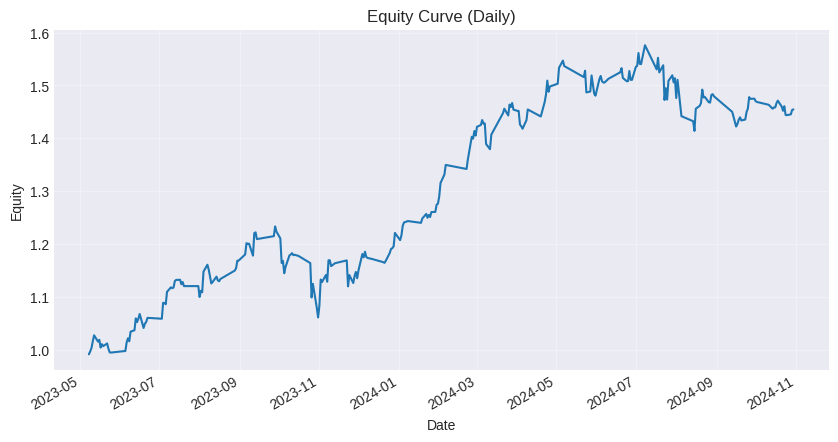

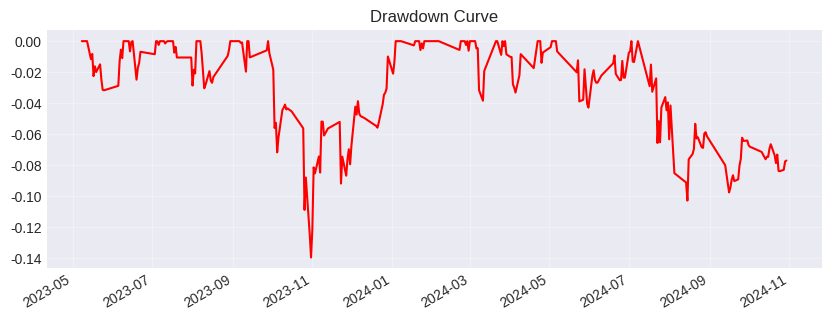

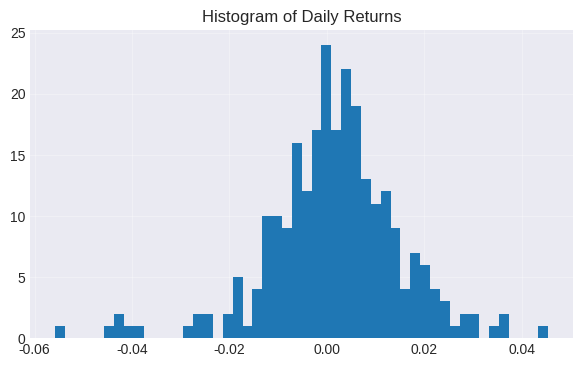

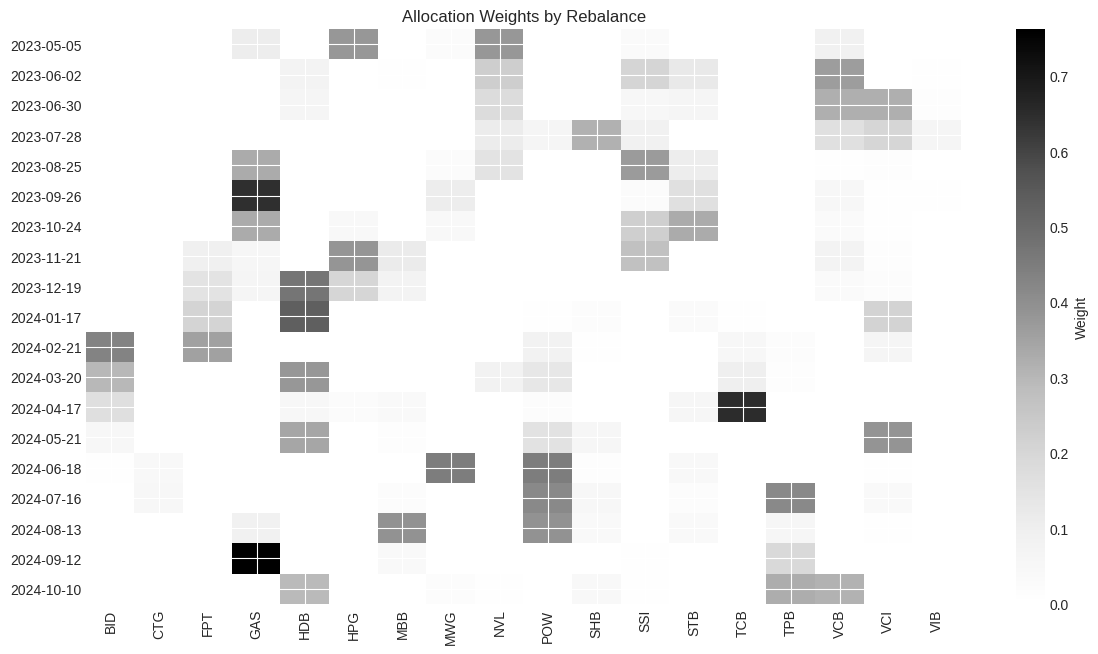

,BID,CTG,FPT,GAS,HDB,HPG,MBB,MWG,NVL,POW,SHB,SSI,STB,TCB,TPB,VCB,VCI,VIB,sum_weight
date,,,,,,,,,,,,,,,,,,,
2023-05-05,0.000000,0.000000,0.000000,0.109640,0.000000,0.375632,0.000000,0.024495,0.375632,0.000000,0.000000,0.030797,0.000000,0.000000,0.000000,0.083797,0.000000,0.000006,1.0
2023-06-02,0.000000,0.000000,0.000000,0.000000,0.073862,0.000000,0.008476,0.000000,0.226557,0.000000,0.000000,0.203126,0.122789,0.000000,0.000000,0.360874,0.000000,0.004316,1.0
2023-06-30,0.000000,0.000000,0.000000,0.000000,0.059602,0.000000,0.000000,0.000000,0.176483,0.000000,0.000000,0.051625,0.060617,0.000000,0.000000,0.321053,0.321053,0.009567,1.0
2023-07-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111835,0.059963,0.314678,0.085858,0.000000,0.000000,0.000000,0.162531,0.199723,0.065413,1.0
2023-08-25,0.000000,0.000000,0.000000,0.329197,0.000000,0.000000,0.000000,0.025916,0.147128,0.000000,0.000000,0.366351,0.109761,0.000000,0.000000,0.006829,0.014818,0.000000,1.0
2023-09-26,0.000000,0.000000,0.000000,0.643200,0.000000,0.000000,0.000000,0.109867,0.000000,0.000000,0.000000,0.023194,0.158610,0.000000,0.000000,0.053137,0.006487,0.005505,1.0
2023-10-24,0.000000,0.000000,0.000000,0.328271,0.000000,0.043930,0.000000,0.039806,0.000000,0.000000,0.000000,0.223335,0.328271,0.000000,0.000000,0.032277,0.004110,0.000000,1.0
2023-11-21,0.000000,0.000000,0.090005,0.057344,0.000000,0.381951,0.114537,0.000000,0.000000,0.000000,0.000000,0.268719,0.000000,0.000000,0.000000,0.073263,0.014181,0.000000,1.0
2023-12-19,0.000000,0.000000,0.146022,0.063566,0.468389,0.200501,0.072792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031433,0.017296,0.000000,1.0


✅ Saved allocations_by_rebalance.csv

Params: TH=0.55, TP=0.15, SL=-0.2, CAP=0.3, TOPK=7, SEED=42


In [138]:
# =========================
# FINAL REPORT — MONTE CARLO 3-STAGE BACKTEST (STABLE)
# =========================
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict

# ==== 1. Fix seed để đảm bảo reproducibility ====

# ==== 2. Input ====
# df: DataFrame với ['ticker','date','close','r1_calc','p_long']
# rebal_dates: list các mốc tái cân bằng
assert {"ticker","date","r1_calc","p_long"}.issubset(df.columns)
assert len(rebal_dates) > 1

df = df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date","ticker"]).reset_index(drop=True)

# ==== 3. Hyperparams tối ưu ====
THRESHOLD = 0.55
TP = 0.15
SL = -0.20
CAP = 0.30
TOPK = 7
WINDOW = 60
HOLD_DAYS = 20
BLOCK = 5
FEE = 0.001  # 0.1% round-turn

# ==== 4. Helper functions ====
def safe_mdd(equity_series):
    eq = pd.Series(equity_series).reset_index(drop=True)
    return float((eq / eq.cummax() - 1).min())

def annualized_stats(equity_curve, daily_dates):
    eq = pd.Series(equity_curve, index=pd.to_datetime(daily_dates))
    rets = eq.pct_change().dropna()
    if len(rets) == 0:
        return np.nan, np.nan, np.nan
    vol = rets.std() * np.sqrt(252)
    vol = float(max(vol, 1e-9))
    total_days = (eq.index[-1] - eq.index[0]).days
    years = total_days / 365.25 if total_days > 0 else np.nan
    cagr = float(eq.iloc[-1] ** (1/years) - 1) if years and years > 0 else np.nan
    sharpe = float(cagr / vol) if np.isfinite(cagr) and vol > 0 else np.nan
    return cagr, vol, sharpe

def monte_carlo_optimize(df_hist, p_long, n_scen=10000, block=BLOCK, tilt_scale=0.002):
    """Monte Carlo 3-stage: sinh 500 kịch bản block bootstrap, tilt nhẹ theo p_long."""
    n_assets = df_hist.shape[1]
    window = len(df_hist)
    n_blocks = max(window - block + 1, 1)
    blocks = [df_hist.iloc[i:i+block].values for i in range(n_blocks)]
    mu_hist = df_hist.mean().values
    drift = 0.5 * mu_hist + 0.5 * (p_long / (np.sum(p_long) + 1e-9)) * tilt_scale

    scen = []
    for _ in range(n_scen):
        idx = np.random.randint(0, n_blocks, size=max(1, HOLD_DAYS // block))
        s = np.vstack([blocks[i] for i in idx])
        s = np.clip(s + drift, -0.10, 0.10)
        scen.append(s)
    scen = np.stack(scen, axis=0)

    all_w = np.random.dirichlet(np.ones(n_assets), size=1000)
    best_idx, best_score = 0, -1e9
    for i, w in enumerate(all_w):
        port = (scen @ w).mean(axis=1)
        mu, sd = port.mean(), port.std() + 1e-6
        score = mu / sd
        if score > best_score:
            best_idx, best_score = i, score
    return all_w[best_idx]

# ==== 5. Backtest ====
def backtest_mc3stage_report(df, rebal_dates, threshold, tp, sl, cap, topk):
    daily_dates, daily_equity = [], []
    equity = 1.0
    weights_panel = []
    per_ticker_trades = defaultdict(list)
    tp_hits_total = sl_hits_total = total_trades = 0

    for d0 in rebal_dates[:-1]:
        d1 = d0 + np.timedelta64(HOLD_DAYS, 'D')

        pool = df[(df["date"] == d0) & (df["p_long"] > threshold)][["ticker","p_long"]]
        if pool.empty: continue
        pool = pool.nlargest(topk, "p_long")
        top = pool["ticker"].tolist()
        p = pool["p_long"].values

        # lịch sử
        hist_cols = []
        for t in top:
            g = df[(df["ticker"] == t) & (df["date"] < d0)].tail(WINDOW)
            if len(g) < max(10, BLOCK):
                hist_cols = []
                break
            hist_cols.append(g.set_index("date")["r1_calc"])
        if len(hist_cols) != len(top): continue

        df_hist = pd.concat(hist_cols, axis=1)
        df_hist.columns = top

        w = monte_carlo_optimize(df_hist, p_long=p, n_scen=500)
        w = np.clip(w, 0, cap)
        if w.sum() <= 0: continue
        w = w / w.sum()

        weights_panel.append((pd.Timestamp(d0), dict(zip(top, w))))

        ret = df[(df["ticker"].isin(top)) & (df["date"] > d0) & (df["date"] <= d1)]
        if ret.empty: continue
        ret_mat = ret.pivot(index="date", columns="ticker", values="r1_calc").reindex(columns=top).fillna(0)
        cum_ret_mat = (1 + ret_mat).cumprod() - 1
        local_equity = equity
        active = np.ones(len(top), dtype=bool)

        for i, (dt, row) in enumerate(ret_mat.iterrows()):
            cum_now = cum_ret_mat.iloc[i].values
            hit_tp, hit_sl = cum_now > tp, cum_now < sl
            active = ~(hit_tp | hit_sl)
            day_ret = float(np.sum(row.values * w * active))
            local_equity *= (1 + day_ret)
            daily_dates.append(pd.Timestamp(dt))
            daily_equity.append(local_equity)

        for j, t in enumerate(top):
            tr = float(cum_ret_mat.iloc[-1, j])
            per_ticker_trades[t].append(tr)
            if tr > tp: tp_hits_total += 1
            if tr < sl: sl_hits_total += 1
            total_trades += 1

        equity = local_equity * (1 - 2 * FEE)

    cagr, vol, sharpe = annualized_stats(daily_equity, daily_dates)
    mdd = safe_mdd(daily_equity)
    win_rate = np.mean([x>0 for lst in per_ticker_trades.values() for x in lst]) if total_trades else None

    uniq = sorted({tk for _, d in weights_panel for tk in d.keys()})
    heat = np.zeros((len(weights_panel), len(uniq)))
    row_labels = []
    for i, (d0, wdict) in enumerate(weights_panel):
        row_labels.append(str(pd.Timestamp(d0).date()))
        for j, tk in enumerate(uniq):
            heat[i, j] = wdict.get(tk, 0.0)

    report = {
        "weights_panel": weights_panel,
        "weights_heat": heat,
        "weight_row_labels": row_labels,
        "weight_col_labels": uniq,
        "equity_series": pd.Series(daily_equity, index=pd.to_datetime(daily_dates)).sort_index(),
        "cagr": cagr, "vol": vol, "sharpe": sharpe, "mdd": mdd,
        "tp_hits": tp_hits_total, "sl_hits": sl_hits_total,
        "total_trades": total_trades, "win_rate": win_rate,
    }
    return report

# ==== 6. Run ====
rep = backtest_mc3stage_report(df, rebal_dates, THRESHOLD, TP, SL, CAP, TOPK)

# ==== 7. Visualization ====
summary = pd.DataFrame({
    "Metric": ["Total trades","TP hits","SL hits","Win rate","CAGR","Volatility","Sharpe","MDD"],
    "Value": [
        rep["total_trades"], rep["tp_hits"], rep["sl_hits"],
        f"{rep['win_rate']*100:.2f}%" if rep['win_rate'] else None,
        f"{rep['cagr']*100:.2f}%", f"{rep['vol']*100:.2f}%", f"{rep['sharpe']:.2f}", f"{rep['mdd']*100:.2f}%"
    ]
})
print(summary.to_string(index=False))

# === Equity curve ===
plt.figure(figsize=(10,5))
rep["equity_series"].plot()
plt.title("Equity Curve (Daily)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.grid(alpha=0.3); plt.show()

# === Drawdown ===
dd = rep["equity_series"]/rep["equity_series"].cummax() - 1
plt.figure(figsize=(10,3.5))
dd.plot(color='r'); plt.title("Drawdown Curve"); plt.grid(alpha=0.3); plt.show()

# === Histogram of daily returns ===
rets = rep["equity_series"].pct_change().dropna()
plt.figure(figsize=(7,4))
plt.hist(rets, bins=50); plt.title("Histogram of Daily Returns")
plt.grid(alpha=0.3); plt.show()

# === Weights heatmap ===
if rep["weights_heat"].size > 0:
    plt.figure(figsize=(12, max(4, 0.35*rep["weights_heat"].shape[0])))
    plt.imshow(rep["weights_heat"], aspect="auto", interpolation="nearest")
    plt.colorbar(label="Weight")
    plt.title("Allocation Weights by Rebalance")
    plt.yticks(ticks=np.arange(len(rep["weight_row_labels"])), labels=rep["weight_row_labels"])
    plt.xticks(ticks=np.arange(len(rep["weight_col_labels"])), labels=rep["weight_col_labels"], rotation=90)
    plt.tight_layout(); plt.show()

# ==== 8. Xuất bảng weights cho 19 chu kỳ ====
rows, all_tickers = [], sorted(rep["weight_col_labels"])
for d0, wdict in rep["weights_panel"]:
    row = {"date": pd.to_datetime(d0)}
    for tk in all_tickers:
        row[tk] = wdict.get(tk, 0.0)
    row["sum_weight"] = sum(wdict.values())
    rows.append(row)

weights_df = pd.DataFrame(rows).set_index("date").sort_index()
display(weights_df)
weights_df.to_csv("/kaggle/working/allocations_by_rebalance.csv")
print("✅ Saved allocations_by_rebalance.csv")

print(f"\nParams: TH={THRESHOLD}, TP={TP}, SL={SL}, CAP={CAP}, TOPK={TOPK}, SEED={SEED}")
